## **Hotel Booking Demand Prediction**


## Get the Hotel booking dataset

**1. From Kaggle:**

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

**2. From Weather API:**


**3. From Events/Holidays data API:**





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
hotel_bookings_df = pd.read_csv('hotel_bookings.csv')
hotel_bookings_df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [ ]:
hotel_bookings_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
hotel_bookings_df['market_segment'].unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

In [ ]:
hotel_bookings_df['arrival_date'] = pd.to_datetime(
    hotel_bookings_df['arrival_date_year'].astype(str) + '-' +
    hotel_bookings_df['arrival_date_month'] + '-' +
    hotel_bookings_df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)


In [ ]:
# Step 2: Extract `origin_country` from the `country` column
hotel_bookings_df['origin_country'] = hotel_bookings_df['country']

# Step 3: Assign `arrival_location` based on the `hotel` column
hotel_bookings_df['arrival_location'] = hotel_bookings_df['hotel'].apply(
    lambda x: 'Lisbon, Portugal' if x == 'City Hotel' else 'Faro, Portugal'
)





In [ ]:
# Prepare unique combinations for Lisbon, Portugal
lisbon_data = hotel_bookings_df[hotel_bookings_df['arrival_location'] == 'Lisbon, Portugal']
lisbon_unique = lisbon_data[['arrival_date']].drop_duplicates()

# Prepare unique combinations for Faro, Portugal
faro_data = hotel_bookings_df[hotel_bookings_df['arrival_location'] == 'Faro, Portugal']
faro_unique = faro_data[['arrival_date']].drop_duplicates()


## **Extracting Weather Data using Weather API from Visualcrossing**




In [ ]:
import requests
from io import StringIO
import pandas as pd

def fetch_and_save_weather(api_key, location, start_date, end_date, output_file):
    """
    Fetch weather data for a location over a date range and save to a CSV file.

    Parameters:
    - api_key: Your Visual Crossing API key.
    - location: The location (e.g., "Lisbon, Portugal").
    - start_date: The start date (YYYY-MM-DD).
    - end_date: The end date (YYYY-MM-DD).
    - output_file: Name of the file to save the weather data.

    Returns:
    - weather_df: A DataFrame containing the weather data.
    """
    base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"
    request_url = f"{base_url}/{location}/{start_date}/{end_date}?unitGroup=metric&include=days&key={api_key}&contentType=csv"

    print(f"Fetching weather data for {location} from {start_date} to {end_date}")
    response = requests.get(request_url)

    if response.status_code == 200:
        data = StringIO(response.text)
        weather_df = pd.read_csv(data)
        # Save to CSV
        weather_df.to_csv(output_file, index=False)
        print(f"Weather data saved to '{output_file}'")
        return weather_df
    else:
        print(f"Failed to fetch data for {location}: {response.status_code}")
        return None


In [ ]:
# # Configuration
# api_key = "NG4YBQ7MRFZLMHM6G8N3KSF8H"

# # Date ranges for Lisbon and Faro
# lisbon_start_date = lisbon_unique['arrival_date'].min().strftime('%Y-%m-%d')
# lisbon_end_date = lisbon_unique['arrival_date'].max().strftime('%Y-%m-%d')
# faro_start_date = faro_unique['arrival_date'].min().strftime('%Y-%m-%d')
# faro_end_date = faro_unique['arrival_date'].max().strftime('%Y-%m-%d')

# # Fetch weather data for Lisbon
# lisbon_weather_df = fetch_and_save_weather(
#     api_key, "Lisbon, Portugal", lisbon_start_date, lisbon_end_date, "lisbon_weather.csv"
# )

# # Fetch weather data for Faro
# faro_weather_df = fetch_and_save_weather(
#     api_key, "Faro, Portugal", faro_start_date, faro_end_date, "faro_weather.csv"
# )


Fetching weather data for Lisbon, Portugal from 2015-07-01 to 2017-08-31
Weather data saved to 'lisbon_weather.csv'
Fetching weather data for Faro, Portugal from 2015-07-01 to 2017-08-31
Weather data saved to 'faro_weather.csv'


In [ ]:
# Combine Lisbon and Faro weather data
if lisbon_weather_df is not None and faro_weather_df is not None:
    combined_weather_df = pd.concat([lisbon_weather_df, faro_weather_df], ignore_index=True)
    combined_weather_df.to_csv('combined_weather_data.csv', index=False)
    print("Combined weather data saved to 'combined_weather_data.csv'")
else:
    print("Failed to fetch weather data for one or more locations.")


Combined weather data saved to 'combined_weather_data.csv'


In [ ]:
combined_weather_df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [ ]:
# # Save the combined weather data to a CSV file
# combined_weather_df.to_csv('combined_weather_data.csv', index=False)
# print("Combined weather data saved to 'combined_weather_data.csv'.")


In [ ]:
def process_combined_weather_data(weather_df):
    """
    Select and rename relevant columns from the combined weather data.
    """
    weather_df['forecast_date'] = pd.to_datetime(weather_df['datetime']).dt.date

    return weather_df[[
        'forecast_date',  # Date of the weather data
        'name',       # Location of the weather data
        'temp',           # Average temperature
        'tempmin',        # Minimum temperature
        'tempmax',        # Maximum temperature
        'feelslike',      # Average "feels like" temperature
        'humidity',       # Humidity level as a percentage
        'precip',         # Total precipitation in mm
        'precipprob',     # Probability of precipitation
        'snow',           # Snowfall amount in mm
        'windgust',       # Maximum wind gust speed in km/h
        'windspeed',      # Average wind speed in km/h
        'visibility',     # Visibility in km
        'cloudcover',     # Percentage of cloud cover
        'conditions',     # General weather conditions (e.g., "Rain", "Cloudy")
    ]].rename(columns={
        'temp': 'avg_temp',
        'tempmin': 'min_temp',
        'tempmax': 'max_temp',
        'feelslike': 'feels_like_temp',
        'precip': 'precipitation',
        'precipprob': 'precipitation_probability',
        'snow': 'snowfall',
        'windgust': 'max_wind_gust',
        'windspeed': 'avg_wind_speed',
        'visibility': 'visibility_km',
        'cloudcover': 'cloud_cover',
        'conditions': 'weather_conditions'
    })


In [ ]:
# # Process the combined weather data
# processed_weather_df = process_combined_weather_data(combined_weather_df)

# # Save the processed data
# processed_weather_df.to_csv('processed_combined_weather_data.csv', index=False)
# print("Processed combined weather data saved to 'processed_combined_weather_data.csv'.")


Processed combined weather data saved to 'processed_combined_weather_data.csv'.


In [ ]:
processed_weather_df = pd.read_csv('processed_combined_weather_data.csv')

processed_weather_df['name'] = processed_weather_df['name'].apply(lambda x: 'Lisbon, Portugal' if x == 'Lisboa, Portugal' else 'Faro, Portugal')

In [ ]:
# Convert forecast_date to datetime
processed_weather_df['forecast_date'] = pd.to_datetime(processed_weather_df['forecast_date'])

processed_weather_df = processed_weather_df.rename(columns={'name': 'location'})

# Ensure location column is clean
print(processed_weather_df[['forecast_date', 'location']].head())


  forecast_date          location
0    2015-07-01  Lisbon, Portugal
1    2015-07-02  Lisbon, Portugal
2    2015-07-03  Lisbon, Portugal
3    2015-07-04  Lisbon, Portugal
4    2015-07-05  Lisbon, Portugal


In [ ]:
# Convert arrival_date to datetime
hotel_bookings_df['arrival_date'] = pd.to_datetime(hotel_bookings_df['arrival_date'])

# Ensure arrival_location is clean
print(hotel_bookings_df[['arrival_date', 'arrival_location']].head())


  arrival_date arrival_location
0   2015-07-01   Faro, Portugal
1   2015-07-01   Faro, Portugal
2   2015-07-01   Faro, Portugal
3   2015-07-01   Faro, Portugal
4   2015-07-01   Faro, Portugal


In [ ]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [ ]:
hotel_bookings_df_orig = hotel_bookings_df.copy()

In [ ]:
# Join weather data to hotel bookings data
hotel_bookings_df = pd.merge(
    hotel_bookings_df_orig,
    processed_weather_df,
    left_on=['arrival_location', 'arrival_date'],
    right_on=['location', 'forecast_date'],
    how='left'
)

# Drop redundant columns after the merge
hotel_bookings_df = hotel_bookings_df.drop(columns=['location', 'forecast_date'])

# Preview the merged dataset
print(hotel_bookings_df.head())


          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [ ]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [ ]:
# # Save the updated dataset to a CSV file
# hotel_bookings_df.to_csv('hotel_bookings_with_weather.csv', index=False)
# print("Merged dataset saved to 'hotel_bookings_with_weather.csv'.")


Merged dataset saved to 'hotel_bookings_with_weather.csv'.


In [ ]:
# hotel_bookings_df = pd.read_csv('hotel_bookings_with_weather.csv')

## **Extract Event or Holiday data for Portugal from 2015 to 2017 using RapidAPI**

In [ ]:
import requests
import pandas as pd

def fetch_public_holidays(api_key, country_code, years):
    """
    Fetch public holiday data for a given country and a range of years.
    Parameters:
    - api_key: Your RapidAPI key.
    - country_code: Country code (e.g., 'PT' for Portugal).
    - years: List of years to fetch data for (e.g., [2015, 2016, 2017]).
    Returns:
    - holidays_df: A DataFrame containing holiday data for all years.
    """
    url_template = "https://public-holidays7.p.rapidapi.com/{year}/{country}"
    headers = {
        "x-rapidapi-key": api_key,
        "x-rapidapi-host": "public-holidays7.p.rapidapi.com"
    }

    holidays_list = []

    for year in years:
        url = url_template.format(year=year, country=country_code)
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            holidays = response.json()
            for holiday in holidays:
                holidays_list.append({
                    "name": holiday.get("name", ""),
                    "date": holiday.get("date", ""),
                    "localName": holiday.get("localName", ""),
                    "countryCode": country_code,
                    "year": year
                })
        else:
            print(f"Failed to fetch data for {country_code} in {year}: {response.status_code}")

    # Convert the list of holidays into a DataFrame
    holidays_df = pd.DataFrame(holidays_list)
    return holidays_df

# Configuration
api_key = "823d0c4142msh2a3a354852b3a4ep13402djsn9c823368e0dd"  # Replace with your API key
country_code = "PT"  # Portugal
years = [2015, 2016, 2017]  # List of years to fetch




In [ ]:
# Fetch holiday data
# holidays_df = fetch_public_holidays(api_key, country_code, years)

# # Save to CSV
# holidays_df.to_csv('portugal_holidays_2015_2017.csv', index=False)

# # Preview the holiday data
# print(holidays_df.head())

             name        date          localName countryCode  year
0  New Year's Day  2015-01-01           Ano Novo          PT  2015
1        Carnival  2015-02-17           Carnaval          PT  2015
2     Good Friday  2015-04-03  Sexta-feira Santa          PT  2015
3   Easter Sunday  2015-04-05  Domingo de Páscoa          PT  2015
4     Freedom Day  2015-04-25   Dia da Liberdade          PT  2015


In [ ]:
holidays_df = pd.read_csv('portugal_holidays_2015_2017.csv')

In [ ]:
# Convert holiday dates to datetime format
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Preview the holiday data
print(holidays_df.head())


             name       date          localName countryCode  year
0  New Year's Day 2015-01-01           Ano Novo          PT  2015
1        Carnival 2015-02-17           Carnaval          PT  2015
2     Good Friday 2015-04-03  Sexta-feira Santa          PT  2015
3   Easter Sunday 2015-04-05  Domingo de Páscoa          PT  2015
4     Freedom Day 2015-04-25   Dia da Liberdade          PT  2015


In [ ]:
# Convert arrival_date to datetime format
hotel_bookings_df['arrival_date'] = pd.to_datetime(hotel_bookings_df['arrival_date'])

# Preview the booking data
print(hotel_bookings_df.head())


          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [ ]:
# Create a flag for whether the arrival date is in a holiday week
hotel_bookings_df['is_holiday_week'] = hotel_bookings_df['arrival_date'].apply(
    lambda arrival_date: holidays_df['date'].apply(
        lambda holiday_date: abs((arrival_date - holiday_date).days) <= 7
    ).any()
)

# Preview the updated dataset
print(hotel_bookings_df[['arrival_date', 'is_holiday_week']].head())


  arrival_date  is_holiday_week
0   2015-07-01             True
1   2015-07-01             True
2   2015-07-01             True
3   2015-07-01             True
4   2015-07-01             True


In [ ]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [ ]:
# Function to find the nearest holiday
def find_nearest_holiday(arrival_date, holidays_df):
    holidays_df['days_diff'] = (holidays_df['date'] - arrival_date).abs().dt.days
    nearest_holiday = holidays_df.loc[holidays_df['days_diff'].idxmin()]
    return nearest_holiday['name'], nearest_holiday['days_diff']

# Add nearest holiday and days to holiday
nearest_holidays = hotel_bookings_df['arrival_date'].apply(lambda x: find_nearest_holiday(x, holidays_df))
hotel_bookings_df['nearest_holiday'] = nearest_holidays.apply(lambda x: x[0])
hotel_bookings_df['days_to_holiday'] = nearest_holidays.apply(lambda x: x[1])

# Preview the updated dataset
print(hotel_bookings_df[['arrival_date', 'is_holiday_week', 'nearest_holiday', 'days_to_holiday']].head())


  arrival_date  is_holiday_week nearest_holiday  days_to_holiday
0   2015-07-01             True     Madeira Day                0
1   2015-07-01             True     Madeira Day                0
2   2015-07-01             True     Madeira Day                0
3   2015-07-01             True     Madeira Day                0
4   2015-07-01             True     Madeira Day                0


In [ ]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [ ]:
# hotel_bookings_df.to_csv('hotel_bookings_with_weather_and_holidays.csv', index=False)
# print("Merged dataset with holiday data saved to 'hotel_bookings_with_weather_and_holidays.csv'.")

Merged dataset with holiday data saved to 'hotel_bookings_with_weather_and_holidays.csv'.


In [ ]:
final_hotel_bookings_df = pd.read_csv('hotel_bookings_with_weather_and_holidays.csv')

In [ ]:
final_hotel_bookings_df

hotel  is_canceled  lead_time  arrival_date_year  \
0       Resort Hotel            0        342               2015   
1       Resort Hotel            0        737               2015   
2       Resort Hotel            0          7               2015   
3       Resort Hotel            0         13               2015   
4       Resort Hotel            0         14               2015   
...              ...          ...        ...                ...   
119385    City Hotel            0         23               2017   
119386    City Hotel            0        102               2017   
119387    City Hotel            0         34               2017   
119388    City Hotel            0        109               2017   
119389    City Hotel            0        205               2017   

       arrival_date_month  arrival_date_week_number  \
0                    July                        27   
1                    July                        27   
2                    July                        27   
3                    July                        27   
4                    July                        27   
...                   ...                       ...   
119385             August                        35   
119386             August                        35   
119387             August                        35   
119388             August                        35   
119389             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
0                               1                        0   
1                               1                        0   
2                               1                        0   
3                               1                        0   
4                               1                        0   
...                           ...                      ...   
119385                         30                        2   
119386                         31                        2   
119387                         31                        2   
119388                         31                        2   
119389                         29                        2   

        stays_in_week_nights  adults  ...  precipitation_probability  \
0                          0       2  ...                          0   
1                          0       2  ...                          0   
2                          1       1  ...                          0   
3                          1       1  ...                          0   
4                          2       2  ...                          0   
...                      ...     ...  ...                        ...   
119385                     5       2  ...                          0   
119386                     5       3  ...                          0   
119387                     5       2  ...                          0   
119388                     5       2  ...                          0   
119389                     7       2  ...                        100   

        snowfall max_wind_gust avg_wind_speed visibility_km cloud_cover  \
0              0          54.0           38.5          11.0        35.6   
1              0          54.0           38.5          11.0        35.6   
2              0          54.0           38.5          11.0        35.6   
3              0          54.0           38.5          11.0        35.6   
4              0          54.0           38.5          11.0        35.6   
...          ...           ...            ...           ...         ...   
119385         0          45.7           24.1          11.0        30.2   
119386         0          47.2           31.1          12.0        22.2   
119387         0          47.2           31.1          12.0        22.2   
119388         0          47.2           31.1          12.0        22.2   
119389         0          38.9           21.9          10.5        43.0   

            weather_conditions  is_hol

In [ ]:
final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
final_hotel_bookings_df['arrival_location'].unique()

array(['Faro, Portugal', 'Lisbon, Portugal'], dtype=object)

## **Data Cleaning**

In [ ]:
null = pd.DataFrame({'Null Values' : final_hotel_bookings_df.isna().sum(), 'Percentage Null Values' : (final_hotel_bookings_df.isna().sum()) / (final_hotel_bookings_df.shape[0]) * (100)})
null

Null Values  Percentage Null Values
hotel                                     0                0.000000
is_canceled                               0                0.000000
lead_time                                 0                0.000000
arrival_date_year                         0                0.000000
arrival_date_month                        0                0.000000
arrival_date_week_number                  0                0.000000
arrival_date_day_of_month                 0                0.000000
stays_in_weekend_nights                   0                0.000000
stays_in_week_nights                      0                0.000000
adults                                    0                0.000000
children                                  4                0.003350
babies                                    0                0.000000
meal                                      0                0.000000
country                                 488                0.408744
market_segment                            0                0.000000
distribution_channel                      0                0.000000
is_repeated_guest                         0                0.000000
previous_cancellations                    0                0.000000
previous_bookings_not_canceled            0                0.000000
reserved_room_type                        0                0.000000
assigned_room_type                        0                0.000000
booking_changes                           0                0.000000
deposit_type                              0                0.000000
agent                                 16340               13.686238
company                              112593               94.306893
days_in_waiting_list                      0                0.000000
customer_type                             0                0.000000
adr                                       0                0.000000
required_car_parking_spaces               0                0.000000
total_of_special_requests                 0                0.000000
reservation_status                        0                0.000000
reservation_status_date                   0                0.000000
arrival_date                              0                0.000000
origin_country                          488                0.408744
arrival_location                          0                0.000000
avg_temp                                  0                0.000000
min_temp                                  0                0.000000
max_temp                                  0                0.000000
feels_like_temp                           0                0.000000
humidity                                  0                0.000000
precipitation                             0                0.000000
precipitation_probability                 0                0.000000
snowfall                                  0                0.000000
max_wind_gust                             0                0.000000
avg_wind_speed                            0                0.000000
visibility_km                             0                0.000000
cloud_cover                               0                0.000000
weather_conditions                        0                0.000000
is_holiday_week                           0                0.000000
nearest_holiday                           0                0.000000
days_to_holiday                           0                0.000000

In [ ]:
final_hotel_bookings_df['company'].value_counts()

company
40.0     927
223.0    784
67.0     267
45.0     250
153.0    215
        ... 
104.0      1
531.0      1
160.0      1
413.0      1
386.0      1
Name: count, Length: 352, dtype: int64

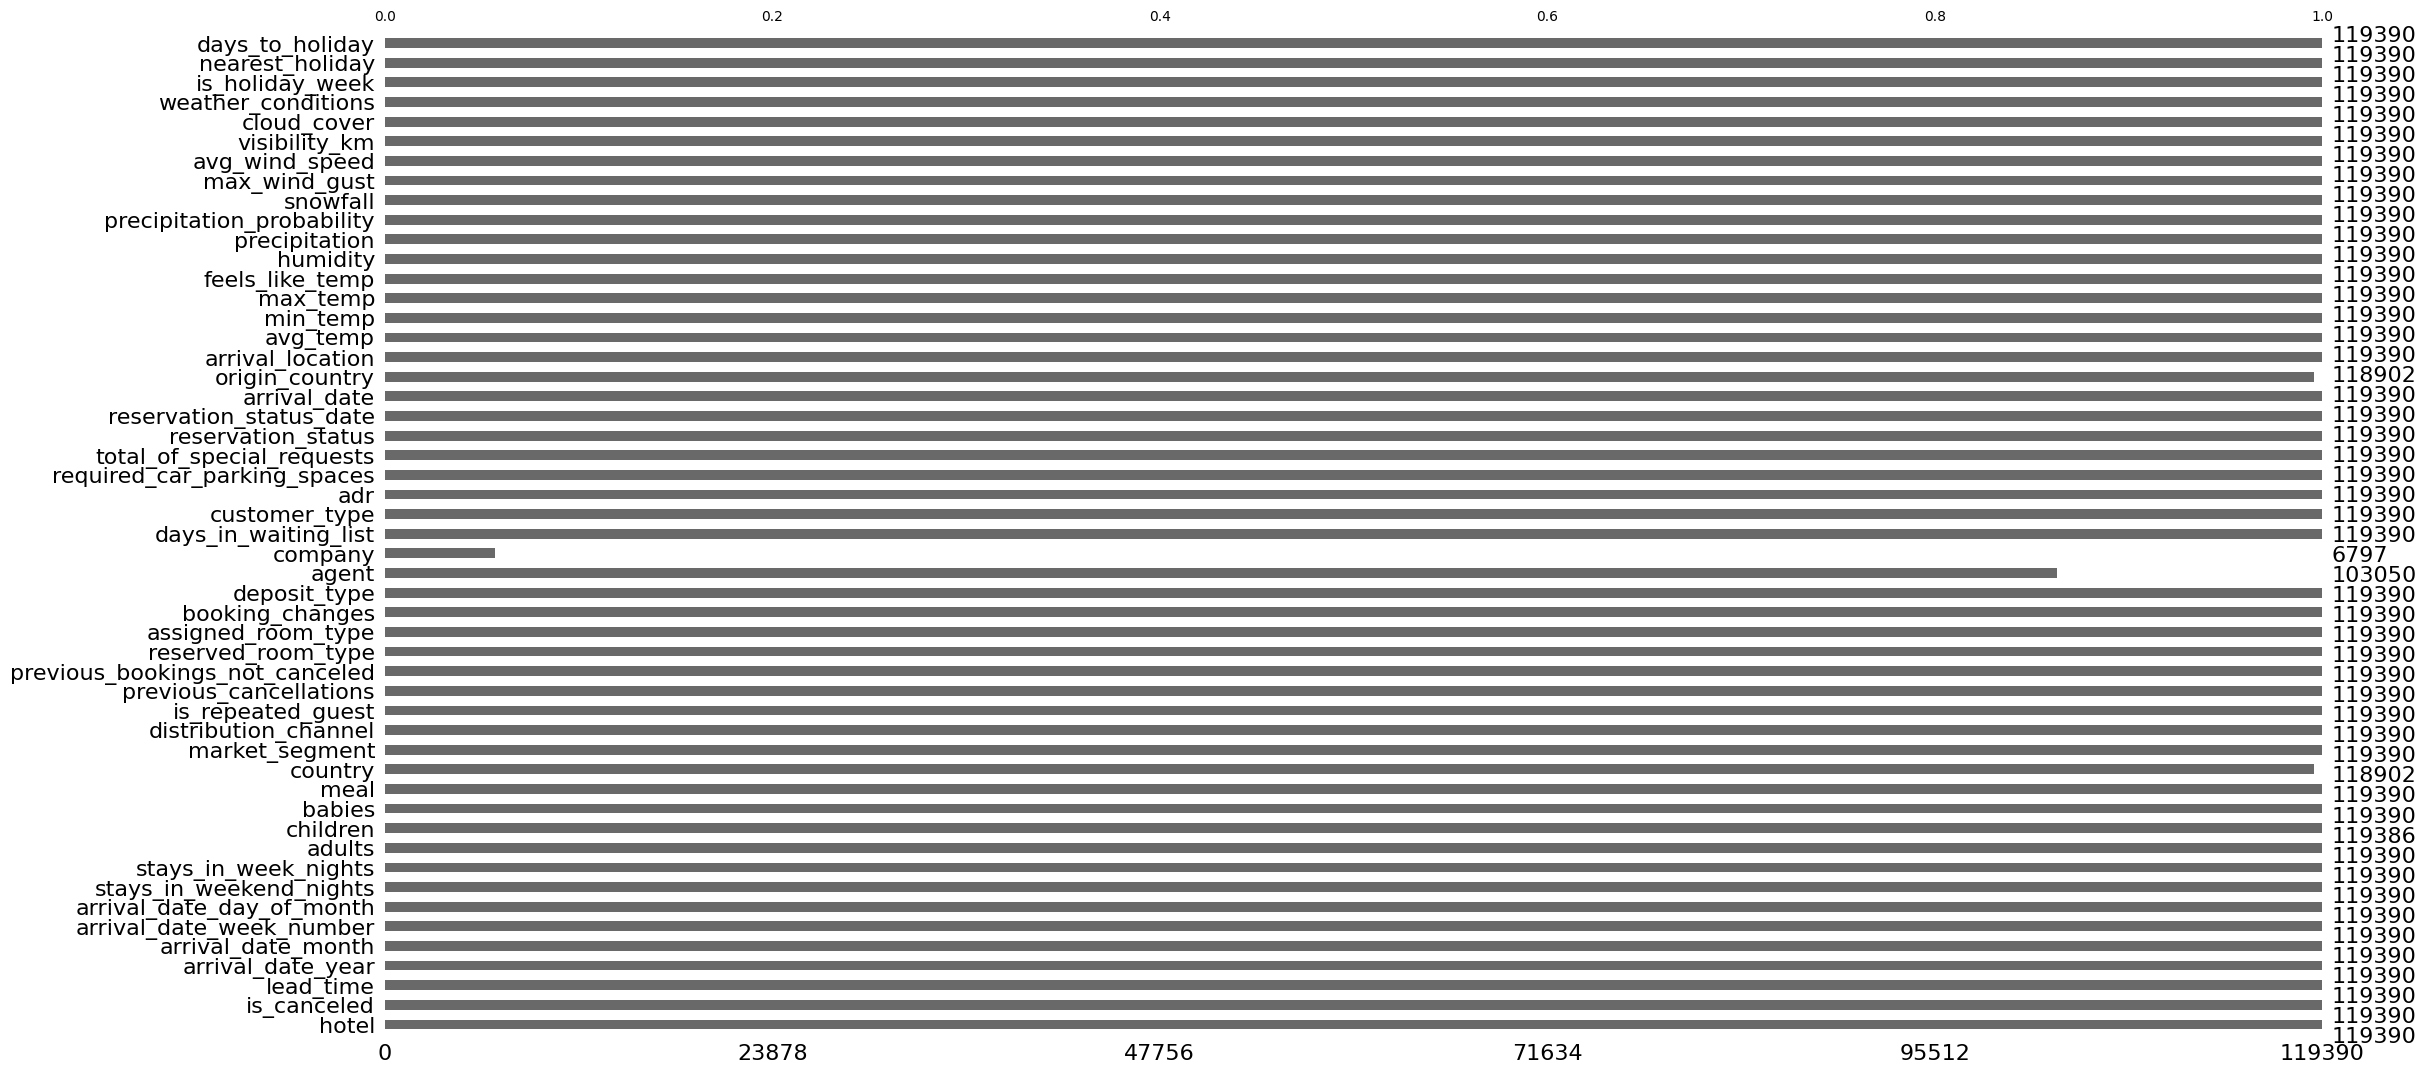

In [ ]:
import missingno as msno

# visualizing null values
msno.bar(final_hotel_bookings_df)
plt.show()

**Dropping Duplicates**

In [ ]:
final_hotel_bookings_df[final_hotel_bookings_df.duplicated()]

hotel  is_canceled  lead_time  arrival_date_year  \
5       Resort Hotel            0         14               2015   
22      Resort Hotel            0         72               2015   
43      Resort Hotel            0         70               2015   
138     Resort Hotel            1          5               2015   
200     Resort Hotel            0          0               2015   
...              ...          ...        ...                ...   
119349    City Hotel            0        186               2017   
119352    City Hotel            0         63               2017   
119353    City Hotel            0         63               2017   
119354    City Hotel            0         63               2017   
119373    City Hotel            0        175               2017   

       arrival_date_month  arrival_date_week_number  \
5                    July                        27   
22                   July                        27   
43                   July                        27   
138                  July                        28   
200                  July                        28   
...                   ...                       ...   
119349             August                        35   
119352             August                        35   
119353             August                        35   
119354             August                        35   
119373             August                        35   

        arrival_date_day_of_month  stays_in_weekend_nights  \
5                               1                        0   
22                              1                        2   
43                              2                        2   
138                             5                        1   
200                             7                        0   
...                           ...                      ...   
119349                         31                        0   
119352                         31                        0   
119353                         31                        0   
119354                         31                        0   
119373                         31                        1   

        stays_in_week_nights  adults  ...  precipitation_probability  \
5                          2       2  ...                          0   
22                         4       2  ...                          0   
43                         3       2  ...                          0   
138                        0       2  ...                          0   
200                        1       1  ...                          0   
...                      ...     ...  ...                        ...   
119349                     3       2  ...                          0   
119352                     3       3  ...                          0   
119353                     3       3  ...                          0   
119354                     3       3  ...                          0   
119373                     3       1  ...                          0   

        snowfall max_wind_gust avg_wind_speed visibility_km cloud_cover  \
5              0          54.0           38.5          11.0        35.6   
22             0          54.0           38.5          11.0        35.6   
43             0          39.6           25.5          12.0         2.0   
138            0          37.4           21.1          11.9         5.0   
200            0          36.4           20.2          11.7        10.2   
...          ...           ...            ...           ...         ...   
119349         0          47.2           31.1          12.0        22.2   
119352         0          47.2           31.1          12.0        22.2   
119353         0          47.2           31.1          12.0        22.2   
119354         0          47.2           31.1          12.0        22.2   
119373         0          47.2           31.1          12.0        22.2   

        weather_conditions  is_holiday

In [ ]:
final_hotel_bookings_df.duplicated().sum()

31994

In [ ]:
final_hotel_bookings_df = final_hotel_bookings_df.drop_duplicates()

In [ ]:
final_hotel_bookings_df.duplicated().sum()

0

**Dropping Columns**

In [ ]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'origin_country', 'arrival_location', 'avg_temp', 'min_temp',
       'max_temp', 'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'i

In [ ]:
final_hotel_bookings_df.drop('company',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_week_number',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_year',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_month',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_day_of_month',inplace=True,axis=1)

<ipython-input-16-d8f2d49b1254>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop('company',inplace=True,axis=1)


In [ ]:
final_hotel_bookings_df.drop('origin_country',inplace=True,axis=1)

<ipython-input-17-37bef889331b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop('origin_country',inplace=True,axis=1)


In [ ]:
final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87392 non-null  float64
 11  babies                          87396 non-null  int64  
 12  meal                            8739

**Handling Missing Values**

In [ ]:
final_hotel_bookings_df['children'] = final_hotel_bookings_df['children'].fillna(final_hotel_bookings_df['children'].median())
final_hotel_bookings_df['agent'] = final_hotel_bookings_df['agent'].fillna(final_hotel_bookings_df['agent'].median())

<ipython-input-19-9a00276c30b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['children'] = final_hotel_bookings_df['children'].fillna(final_hotel_bookings_df['children'].median())
<ipython-input-19-9a00276c30b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['agent'] = final_hotel_bookings_df['agent'].fillna(final_hotel_bookings_df['agent'].median())


In [ ]:
# find which country is more frequent in our data
print(final_hotel_bookings_df['country'].mode())


0    PRT
Name: country, dtype: object


In [ ]:
final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode()[0], inplace=True)

<ipython-input-21-78b48c7fcc05>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode()[0], inplace=True)
<ipython-input-21-78b48c7fcc05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode

In [ ]:
null_counts = final_hotel_bookings_df.isnull().sum().reset_index()
null_counts.columns = ['Column', 'MissingValues']
null_counts

Column  MissingValues
0                            hotel              0
1                      is_canceled              0
2                        lead_time              0
3                arrival_date_year              0
4               arrival_date_month              0
5         arrival_date_week_number              0
6        arrival_date_day_of_month              0
7          stays_in_weekend_nights              0
8             stays_in_week_nights              0
9                           adults              0
10                        children              0
11                          babies              0
12                            meal              0
13                         country              0
14                  market_segment              0
15            distribution_channel              0
16               is_repeated_guest              0
17          previous_cancellations              0
18  previous_bookings_not_canceled              0
19              reserved_room_type              0
20              assigned_room_type              0
21                 booking_changes              0
22                    deposit_type              0
23                           agent              0
24            days_in_waiting_list              0
25                   customer_type              0
26                             adr              0
27     required_car_parking_spaces              0
28       total_of_special_requests              0
29              reservation_status              0
30         reservation_status_date              0
31                    arrival_date              0
32                arrival_location              0
33                        avg_temp              0
34                        min_temp              0
35                        max_temp              0
36                 feels_like_temp              0
37                        humidity              0
38                   precipitation              0
39       precipitation_probability              0
40                        snowfall              0
41                   max_wind_gust              0
42                  avg_wind_speed              0
43                   visibility_km              0
44                     cloud_cover              0
45              weather_conditions              0
46                 is_holiday_week              0
47                 nearest_holiday              0
48                 days_to_holiday              0

**Check for Miswritings**

In [ ]:
df_cleaned = pd.DataFrame(final_hotel_bookings_df, columns=["hotel",  "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "reservation_status"])
for col in df_cleaned:
   print(col, df_cleaned[col].unique())

hotel ['Resort Hotel' 'City Hotel']
country ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC'
 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU'
 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA' 'KHM'
 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP' 'GLP'
 'KEN' 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'FRO' 'MMR' 'PAN' 'BFA' 'LBY' 'MLI'
 'NAM' '

**Drop Rows with logical errors**

In [ ]:
count_0 = final_hotel_bookings_df[(final_hotel_bookings_df.children == 0) & (final_hotel_bookings_df.adults == 0) & (final_hotel_bookings_df.babies == 0)].shape[0]
count_0

166

In [ ]:
logic_error = final_hotel_bookings_df[(final_hotel_bookings_df['children'] == 0) & (final_hotel_bookings_df['adults'] == 0) & (final_hotel_bookings_df['babies'] == 0)].index
final_hotel_bookings_df.drop(logic_error , inplace=True)

final_hotel_bookings_df.reset_index(drop=True, inplace=True)
final_hotel_bookings_df.head()

<ipython-input-25-5e1f09657feb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop(logic_error , inplace=True)


hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0                     0       2  ...   
2                        0                     1       1  ...   
3                        0                     1       1  ...   
4                        0                     2       2  ...   

   precipitation_probability  snowfall max_wind_gust avg_wind_speed  \
0                          0         0          54.0           38.5   
1                          0         0          54.0           38.5   
2                          0         0          54.0           38.5   
3                          0         0          54.0           38.5   
4                          0         0          54.0           38.5   

  visibility_km cloud_cover  weather_conditions  is_holiday_week  \
0          11.0        35.6    Partially cloudy             True   
1          11.0        35.6    Partially cloudy             True   
2          11.0        35.6    Partially cloudy             True   
3          11.0        35.6    Partially cloudy             True   
4          11.0        35.6    Partially cloudy             True   

   nearest_holiday days_to_holiday  
0      Madeira Day               0  
1      Madeira Day               0  
2      Madeira Day               0  
3      Madeira Day               0  
4      Madeira Day               0  

[5 rows x 49 columns]

In [ ]:
count_0 = final_hotel_bookings_df[(final_hotel_bookings_df.children == 0) & (final_hotel_bookings_df.adults == 0) & (final_hotel_bookings_df.babies == 0)].shape[0]
count_0

0

**Save the Cleaned Dataset**

In [ ]:
# final_hotel_bookings_df.to_csv('final_hotel_bookings_df_cleaned.csv', index=False)

In [ ]:
final_hotel_bookings_df

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
2      Resort Hotel            0          7               2015   
3      Resort Hotel            0         13               2015   
4      Resort Hotel            0         14               2015   
...             ...          ...        ...                ...   
87225    City Hotel            0         23               2017   
87226    City Hotel            0        102               2017   
87227    City Hotel            0         34               2017   
87228    City Hotel            0        109               2017   
87229    City Hotel            0        205               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
2                   July                        27                          1   
3                   July                        27                          1   
4                   July                        27                          1   
...                  ...                       ...                        ...   
87225             August                        35                         30   
87226             August                        35                         31   
87227             August                        35                         31   
87228             August                        35                         31   
87229             August                        35                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                            0                     0       2  ...   
1                            0                     0       2  ...   
2                            0                     1       1  ...   
3                            0                     1       1  ...   
4                            0                     2       2  ...   
...                        ...                   ...     ...  ...   
87225                        2                     5       2  ...   
87226                        2                     5       3  ...   
87227                        2                     5       2  ...   
87228                        2                     5       2  ...   
87229                        2                     7       2  ...   

       precipitation_probability  snowfall max_wind_gust avg_wind_speed  \
0                              0         0          54.0           38.5   
1                              0         0          54.0           38.5   
2                              0         0          54.0           38.5   
3                              0         0          54.0           38.5   
4                              0         0          54.0           38.5   
...                          ...       ...           ...            ...   
87225                          0         0          45.7           24.1   
87226                          0         0          47.2           31.1   
87227                          0         0          47.2           31.1   
87228                          0         0          47.2           31.1   
87229                        100         0          38.9           21.9   

      visibility_km cloud_cover      weather_conditions  is_holiday_week  \
0              11.0        35.6        Partially cloudy             True   
1              11.0        35.6        Partially cloudy             True   
2              11.0        35.6        Partially cloudy             True   
3              11.0        35.6        Partially cloudy             True   
4              11.0        35.6        Partially cloudy             True   
...             ...         ...                     ...       

In [ ]:
final_hotel_bookings_df = pd.read_csv('final_hotel_bookings_df_cleaned.csv')

In [ ]:

final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87230 entries, 0 to 87229
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87230 non-null  object 
 1   is_canceled                     87230 non-null  int64  
 2   lead_time                       87230 non-null  int64  
 3   arrival_date_year               87230 non-null  int64  
 4   arrival_date_month              87230 non-null  object 
 5   arrival_date_week_number        87230 non-null  int64  
 6   arrival_date_day_of_month       87230 non-null  int64  
 7   stays_in_weekend_nights         87230 non-null  int64  
 8   stays_in_week_nights            87230 non-null  int64  
 9   adults                          87230 non-null  int64  
 10  children                        87230 non-null  float64
 11  babies                          87230 non-null  int64  
 12  meal                            

## **EDA**

**What are the main countries or regions guests travel from?**

In [ ]:
# get number of acutal guests by country
country_data = pd.DataFrame(final_hotel_bookings_df.loc[final_hotel_bookings_df["is_canceled"] == 0]["country"].value_counts().reset_index())
country_data.columns = ["country", "Number of Guests"]
#country_data.set_index("country", inplace=True
#country_data.index.name = "country"
#country_data.rename(columns={"country": "Number of Guests"}, inplace=True)


In [ ]:
country_data

country  Number of Guests
0       PRT             17991
1       GBR              8440
2       FRA              7091
3       ESP              5382
4       DEU              4332
..      ...               ...
160     ZMB                 1
161     SYC                 1
162     MDG                 1
163     SMR                 1
164     FRO                 1

[165 rows x 2 columns]

In [ ]:
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
# country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [ ]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data['country'],
                    color=country_data["Guests in %"],
                    hover_name=country_data['country'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

**How much do guests pay for a room per night?**

In [ ]:
data = final_hotel_bookings_df[final_hotel_bookings_df['is_canceled'] == 0]

px.box(data_frame = data, x = 'reserved_room_type', y = 'adr', color = 'hotel', title = 'ADR per room night',template = 'plotly_dark')

**How does the price vary per night over the year?**

In [ ]:
data_resort = final_hotel_bookings_df[(final_hotel_bookings_df['hotel'] == 'Resort Hotel') & (final_hotel_bookings_df['is_canceled'] == 0)]
data_city = final_hotel_bookings_df[(final_hotel_bookings_df['hotel'] == 'City Hotel') & (final_hotel_bookings_df['is_canceled'] == 0)]

In [ ]:
resort_hotel = data_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
resort_hotel

arrival_date_month         adr
0               April   76.841664
1              August  182.103524
2            December   64.072826
3            February   53.624311
4             January   48.599615
5                July  150.914540
6                June  109.026942
7               March   57.110018
8                 May   77.725129
9            November   48.956548
10            October   62.634853
11          September   98.855456

In [ ]:
city_hotel=data_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_hotel

arrival_date_month         adr
0               April  114.251636
1              August  122.825388
2            December   90.769559
3            February   88.210810
4             January   83.378062
5                July  120.069489
6                June  120.673753
7               March   91.306933
8                 May  124.825944
9            November   88.271089
10            October  105.517410
11          September  116.973279

In [ ]:
final_hotel = resort_hotel.merge(city_hotel, on = 'arrival_date_month')
final_hotel.columns = ['month', 'price_for_resort', 'price_for_city_hotel']
final_hotel

month  price_for_resort  price_for_city_hotel
0       April         76.841664            114.251636
1      August        182.103524            122.825388
2    December         64.072826             90.769559
3    February         53.624311             88.210810
4     January         48.599615             83.378062
5        July        150.914540            120.069489
6        June        109.026942            120.673753
7       March         57.110018             91.306933
8         May         77.725129            124.825944
9    November         48.956548             88.271089
10    October         62.634853            105.517410
11  September         98.855456            116.973279

In [ ]:
!pip install sort-dataframeby-monthorweek

!pip install sorted-months-weekdays

  Preparing metadata (setup.py) ... done
  Created wheel for sort-dataframeby-monthorweek: filename=sort_dataframeby_monthorweek-0.4-py3-none-any.whl size=3421 sha256=218ac325350f50bdce289496fbd47a6b9c24cb8cd1ec289208a6a5ccd60c0858
  Stored in directory: /root/.cache/pip/wheels/ac/4c/ca/134c7282a08e7e2b149b1da1975c6686a262c15a92b78adcc7
Successfully built sort-dataframeby-monthorweek
  Preparing metadata (setup.py) ... done
  Created wheel for sorted-months-weekdays: filename=sorted_months_weekdays-0.2-py3-none-any.whl size=3225 sha256=bee847739d372e5ca1fca4d4236efe374053a7bc2a48b2e9ef8f756ac415fb2a
  Stored in directory: /root/.cache/pip/wheels/4d/4f/f5/d9e3e3e60d80b3cdc2f69dfcf0d4bc45257abdea94f2035dbb
Successfully built sorted-months-weekdays


In [ ]:
import sort_dataframeby_monthorweek as sd

def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [ ]:
final_prices = sort_month(final_hotel, 'month')
final_prices

month  price_for_resort  price_for_city_hotel
0     January         48.599615             83.378062
1    February         53.624311             88.210810
2       March         57.110018             91.306933
3       April         76.841664            114.251636
4         May         77.725129            124.825944
5        June        109.026942            120.673753
6        July        150.914540            120.069489
7      August        182.103524            122.825388
8   September         98.855456            116.973279
9     October         62.634853            105.517410
10   November         48.956548             88.271089
11   December         64.072826             90.769559

In [ ]:
plt.figure(figsize = (17, 8))

px.line(final_prices, x = 'month', y = ['price_for_resort','price_for_city_hotel'],
        title = 'Room price per night over the Months', template = 'plotly_dark')

<Figure size 1700x800 with 0 Axes>

**Reservation status in different hotels**

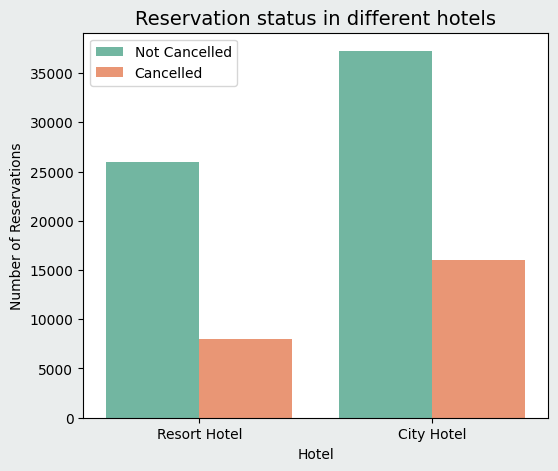

In [ ]:
# Set the background color of the figure
plt.figure(figsize=(6, 5), facecolor='#EAEDED')

# Create the countplot
ax1 = sns.countplot(x='hotel', hue='is_canceled', data=final_hotel_bookings_df, palette="Set2")

# Customize legend location
legend_labels, _ = ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor=(1, 1))

# Set plot title and axis labels
plt.title('Reservation status in different hotels', size=14, color='Black')
plt.xlabel('Hotel',color='Black')
plt.ylabel('Number of Reservations', color='Black')

# Customize legend labels
plt.legend(['Not Cancelled', 'Cancelled'])

# Show the plot
plt.show()

**Arriving year, Leadtime and Cancelations**

In [ ]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'arrival_location', 'avg_temp', 'min_temp', 'max_temp',
       'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'is_holiday_week', 'nearest_hol

Text(0.5, 1.0, 'Arriving year, Leadtime and Cancelations')

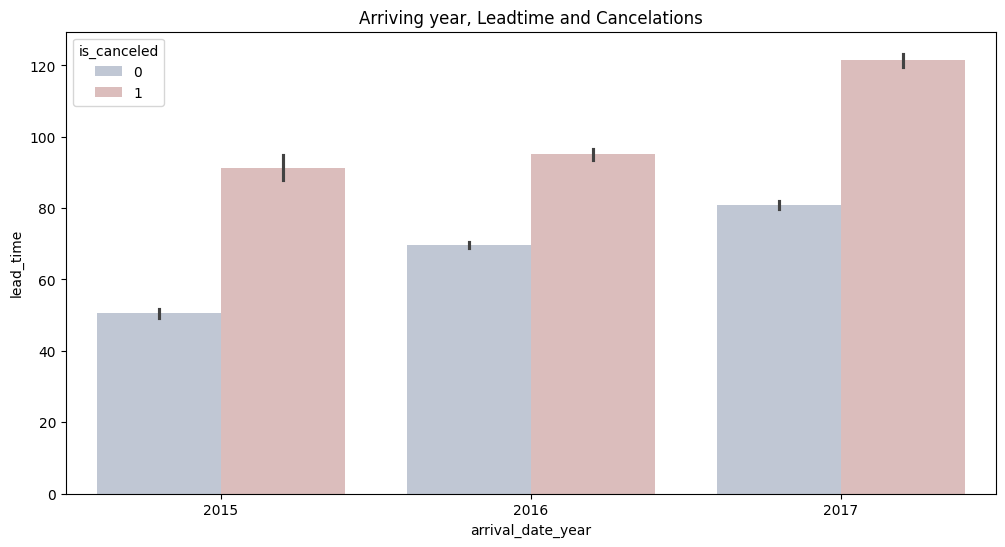

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='arrival_date_year', y='lead_time',hue='is_canceled', data= final_hotel_bookings_df, palette='vlag')
plt.title('Arriving year, Leadtime and Cancelations')

**Which are the most busy months?**

In [ ]:
resort_guests = data_resort['arrival_date_month'].value_counts().reset_index()
resort_guests.columns=['month','no of guests']
resort_guests

month  no of guests
0      August          3153
1        July          3013
2         May          2246
3     October          2209
4       March          2191
5       April          2169
6    February          2053
7        June          1926
8   September          1875
9    November          1744
10   December          1716
11    January          1687

In [ ]:
city_guests = data_city['arrival_date_month'].value_counts().reset_index()
city_guests.columns=['month','no of guests']
city_guests

month  no of guests
0      August          4467
1        July          3834
2         May          3656
3        June          3477
4       March          3469
5       April          3325
6   September          3166
7     October          3070
8    February          2618
9    November          2177
10   December          2019
11    January          1961

In [ ]:
final_guests = resort_guests.merge(city_guests,on='month')
final_guests.columns=['month','no of guests in resort','no of guest in city hotel']
final_guests

month  no of guests in resort  no of guest in city hotel
0      August                    3153                       4467
1        July                    3013                       3834
2         May                    2246                       3656
3     October                    2209                       3070
4       March                    2191                       3469
5       April                    2169                       3325
6    February                    2053                       2618
7        June                    1926                       3477
8   September                    1875                       3166
9    November                    1744                       2177
10   December                    1716                       2019
11    January                    1687                       1961

In [ ]:
final_guests = sort_month(final_guests,'month')
final_guests

month  no of guests in resort  no of guest in city hotel
0     January                    1687                       1961
1    February                    2053                       2618
2       March                    2191                       3469
3       April                    2169                       3325
4         May                    2246                       3656
5        June                    1926                       3477
6        July                    3013                       3834
7      August                    3153                       4467
8   September                    1875                       3166
9     October                    2209                       3070
10   November                    1744                       2177
11   December                    1716                       2019

In [ ]:
px.line(final_guests, x = 'month', y = ['no of guests in resort','no of guest in city hotel'],
        title='Total no of guests per Months', template = 'plotly_dark')

**How long do people stay at the hotels?**

In [ ]:
filter = final_hotel_bookings_df['is_canceled'] == 0
data = final_hotel_bookings_df[filter]
data.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0                     0       2  ...   
2                        0                     1       1  ...   
3                        0                     1       1  ...   
4                        0                     2       2  ...   

   precipitation_probability  snowfall max_wind_gust avg_wind_speed  \
0                          0         0          54.0           38.5   
1                          0         0          54.0           38.5   
2                          0         0          54.0           38.5   
3                          0         0          54.0           38.5   
4                          0         0          54.0           38.5   

  visibility_km cloud_cover  weather_conditions  is_holiday_week  \
0          11.0        35.6    Partially cloudy             True   
1          11.0        35.6    Partially cloudy             True   
2          11.0        35.6    Partially cloudy             True   
3          11.0        35.6    Partially cloudy             True   
4          11.0        35.6    Partially cloudy             True   

   nearest_holiday days_to_holiday  
0      Madeira Day               0  
1      Madeira Day               0  
2      Madeira Day               0  
3      Madeira Day               0  
4      Madeira Day               0  

[5 rows x 49 columns]

In [ ]:
data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
data.head()

<ipython-input-55-a6d36badedd5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  snowfall  \
0                        0                     0       2  ...         0   
1                        0                     0       2  ...         0   
2                        0                     1       1  ...         0   
3                        0                     1       1  ...         0   
4                        0                     2       2  ...         0   

   max_wind_gust avg_wind_speed visibility_km cloud_cover weather_conditions  \
0           54.0           38.5          11.0        35.6   Partially cloudy   
1           54.0           38.5          11.0        35.6   Partially cloudy   
2           54.0           38.5          11.0        35.6   Partially cloudy   
3           54.0           38.5          11.0        35.6   Partially cloudy   
4           54.0           38.5          11.0        35.6   Partially cloudy   

   is_holiday_week  nearest_holiday  days_to_holiday total_nights  
0             True      Madeira Day                0            0  
1             True      Madeira Day                0            0  
2             True      Madeira Day                0            1  
3             True      Madeira Day                0            1  
4             True      Madeira Day                0            2  

[5 rows x 50 columns]

In [ ]:
stay = data.groupby(['total_nights', 'hotel']).agg('count').reset_index()
stay = stay.iloc[:, :3]
stay = stay.rename(columns={'is_canceled':'Number of stays'})
stay

total_nights         hotel  Number of stays
0              0    City Hotel              218
1              0  Resort Hotel              350
2              1    City Hotel             7972
3              1  Resort Hotel             6036
4              2    City Hotel             7630
..           ...           ...              ...
57            46  Resort Hotel                1
58            48    City Hotel                1
59            56  Resort Hotel                1
60            60  Resort Hotel                1
61            69  Resort Hotel                1

[62 rows x 3 columns]

In [ ]:
px.bar(data_frame = stay, x = 'total_nights', y = 'Number of stays', color = 'hotel', barmode = 'group',title='Total no of stays per nights',
        template = 'plotly_dark')

In [ ]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'arrival_location', 'avg_temp', 'min_temp', 'max_temp',
       'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'is_holiday_week', 'nearest_hol

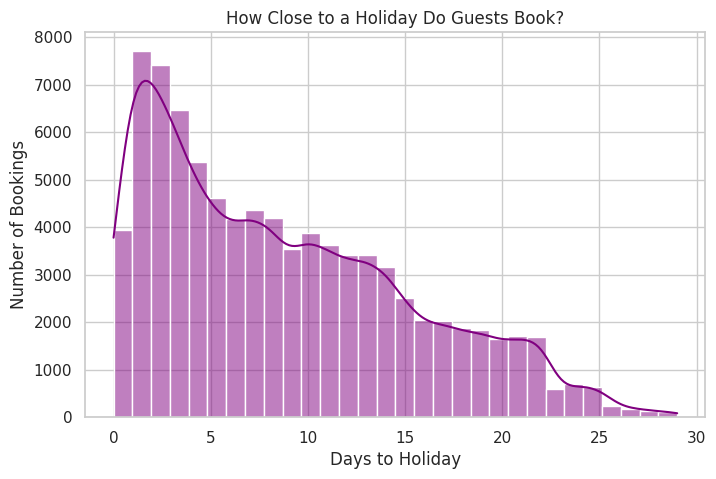

<ipython-input-136-62c577371d33>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




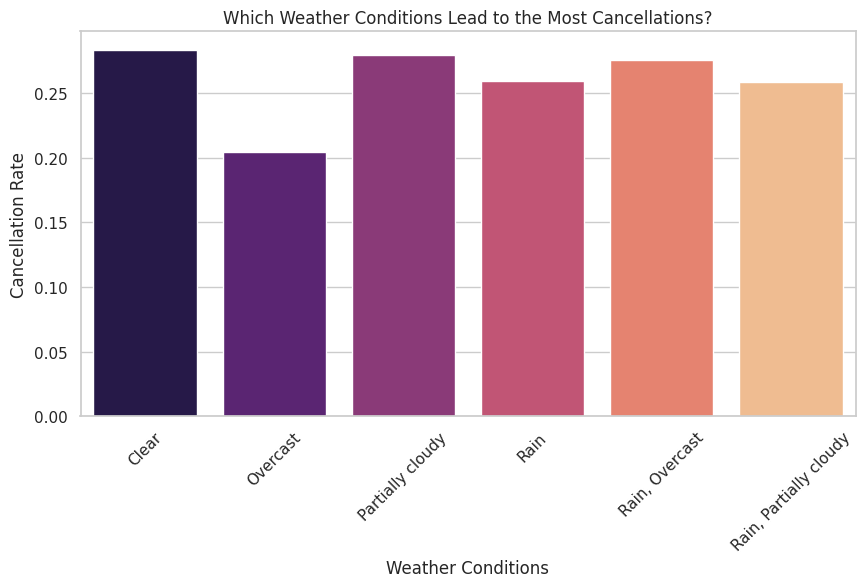

<ipython-input-136-62c577371d33>:46: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-136-62c577371d33>:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




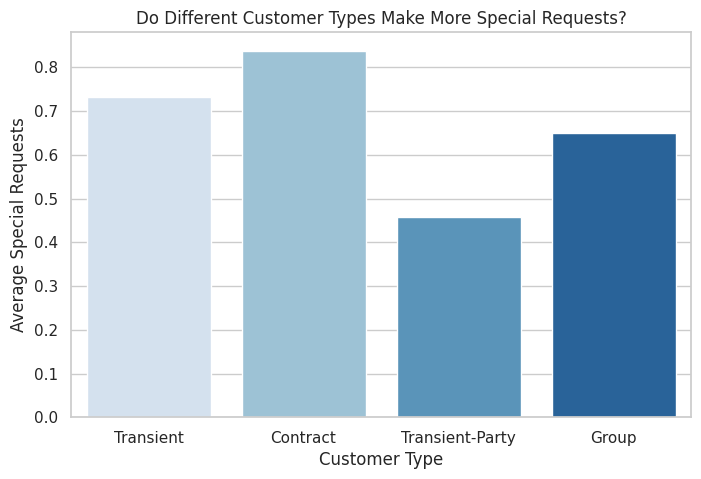

In [ ]:
df = final_hotel_bookings_df.copy()


# Convert dates to datetime format
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Set Seaborn style
sns.set(style="whitegrid")

# ---- 1. Seaborn: How Close to a Holiday Do Guests Book? ----
plt.figure(figsize=(8, 5))
sns.histplot(df["days_to_holiday"], bins=30, kde=True, color="purple")
plt.title("How Close to a Holiday Do Guests Book?")
plt.xlabel("Days to Holiday")
plt.ylabel("Number of Bookings")
plt.show()

# ---- 2. Matplotlib: How Does Weather Impact Cancellation Rates? ----
plt.figure(figsize=(10, 5))
weather_cancellation = df.groupby("weather_conditions")["is_canceled"].mean().reset_index()
sns.barplot(x="weather_conditions", y="is_canceled", data=weather_cancellation, palette="magma")
plt.xticks(rotation=45)
plt.title("Which Weather Conditions Lead to the Most Cancellations?")
plt.xlabel("Weather Conditions")
plt.ylabel("Cancellation Rate")
plt.show()

# ---- 3. Plotly: Lead Time Distribution by Market Segment ----
fig3 = px.box(df, x="market_segment", y="lead_time", color="market_segment",
              title="How Far in Advance Do Guests Book? (By Market Segment)",
              labels={'market_segment': "Market Segment", 'lead_time': "Lead Time (Days)"},
              boxmode="group")
fig3.show()

# ---- 4. Plotly: ADR Trends Over Time ----
df["arrival_month_year"] = df["arrival_date"].dt.to_period("M").astype(str)
adr_trend = df.groupby("arrival_month_year")["adr"].mean().reset_index()
fig4 = px.line(adr_trend, x="arrival_month_year", y="adr",
               title="How Does ADR Change Over Time?",
               labels={'arrival_month_year': "Month", 'adr': "Average Daily Rate"},
               markers=True)
fig4.show()

# ---- 5. Seaborn: Impact of Customer Type on Special Requests ----
plt.figure(figsize=(8, 5))
sns.barplot(x="customer_type", y="total_of_special_requests", data=df, palette="Blues", ci=None)
plt.title("Do Different Customer Types Make More Special Requests?")
plt.xlabel("Customer Type")
plt.ylabel("Average Special Requests")
plt.show()


## **PCA**


Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving as much variance as possible. It does this by identifying new axes, called principal components, which are linear combinations of the original variables. The first principal component captures the maximum variance in the data, while each subsequent component captures progressively less variance. PCA is widely used for data visualization, noise reduction, and improving computational efficiency by reducing redundant features while maintaining essential information.

In [ ]:
pca_df = pd.read_csv('final_hotel_bookings_df_cleaned.csv')

In [ ]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87230 entries, 0 to 87229
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87230 non-null  object 
 1   is_canceled                     87230 non-null  int64  
 2   lead_time                       87230 non-null  int64  
 3   arrival_date_year               87230 non-null  int64  
 4   arrival_date_month              87230 non-null  object 
 5   arrival_date_week_number        87230 non-null  int64  
 6   arrival_date_day_of_month       87230 non-null  int64  
 7   stays_in_weekend_nights         87230 non-null  int64  
 8   stays_in_week_nights            87230 non-null  int64  
 9   adults                          87230 non-null  int64  
 10  children                        87230 non-null  float64
 11  babies                          87230 non-null  int64  
 12  meal                            

In [ ]:
pca_df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0                     0       2  ...   
2                        0                     1       1  ...   
3                        0                     1       1  ...   
4                        0                     2       2  ...   

   precipitation_probability  snowfall max_wind_gust avg_wind_speed  \
0                          0         0          54.0           38.5   
1                          0         0          54.0           38.5   
2                          0         0          54.0           38.5   
3                          0         0          54.0           38.5   
4                          0         0          54.0           38.5   

  visibility_km cloud_cover  weather_conditions  is_holiday_week  \
0          11.0        35.6    Partially cloudy             True   
1          11.0        35.6    Partially cloudy             True   
2          11.0        35.6    Partially cloudy             True   
3          11.0        35.6    Partially cloudy             True   
4          11.0        35.6    Partially cloudy             True   

   nearest_holiday days_to_holiday  
0      Madeira Day               0  
1      Madeira Day               0  
2      Madeira Day               0  
3      Madeira Day               0  
4      Madeira Day               0  

[5 rows x 49 columns]

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Identify and remove categorical columns
categorical_columns = pca_df.select_dtypes(include=['object', 'bool']).columns

# Identify categorical-encoded labels to remove
categorical_encoded_columns = ['is_canceled', 'is_repeated_guest', 'arrival_date_year']

# Remove categorical and categorical-encoded columns
df_pca_ready = pca_df.drop(columns=list(categorical_columns) + categorical_encoded_columns, axis=1)

# Normalize the numerical data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca_ready)

# Convert back to DataFrame for readability
df_scaled = pd.DataFrame(df_scaled, columns=df_pca_ready.columns)

df_scaled


lead_time  arrival_date_week_number  arrival_date_day_of_month  \
0       3.044788                  0.012064                  -1.676854   
1       7.634706                  0.012064                  -1.676854   
2      -0.847926                  0.012064                  -1.676854   
3      -0.778206                  0.012064                  -1.676854   
4      -0.766586                  0.012064                  -1.676854   
...          ...                       ...                        ...   
87225  -0.662006                  0.597324                   1.605362   
87226   0.255978                  0.597324                   1.718542   
87227  -0.534185                  0.597324                   1.718542   
87228   0.337318                  0.597324                   1.718542   
87229   1.452842                  0.597324                   1.492182   

       stays_in_weekend_nights  stays_in_week_nights    adults  children  \
0                    -0.977814             -1.286352  0.194034 -0.304424   
1                    -0.977814             -1.286352  0.194034 -0.304424   
2                    -0.977814             -0.796113 -1.414406 -0.304424   
3                    -0.977814             -0.796113 -1.414406 -0.304424   
4                    -0.977814             -0.305873  0.194034 -0.304424   
...                        ...                   ...       ...       ...   
87225                 0.968843              1.164846  0.194034 -0.304424   
87226                 0.968843              1.164846  1.802474 -0.304424   
87227                 0.968843              1.164846  0.194034 -0.304424   
87228                 0.968843              1.164846  0.194034 -0.304424   
87229                 0.968843              2.145325  0.194034 -0.304424   

         babies  previous_cancellations  previous_bookings_not_canceled  ...  \
0     -0.095379               -0.082315                       -0.106204  ...   
1     -0.095379               -0.082315                       -0.106204  ...   
2     -0.095379               -0.082315                       -0.106204  ...   
3     -0.095379               -0.082315                       -0.106204  ...   
4     -0.095379               -0.082315                       -0.106204  ...   
...         ...                     ...                             ...  ...   
87225 -0.095379               -0.082315                       -0.106204  ...   
87226 -0.095379               -0.082315                       -0.106204  ...   
87227 -0.095379               -0.082315                       -0.106204  ...   
87228 -0.095379               -0.082315                       -0.106204  ...   
87229 -0.095379               -0.082315                       -0.106204  ...   

       feels_like_temp  humidity  precipitation  precipitation_probability  \
0             0.502384  0.354578      -0.279184                  -0.572682   
1             0.502384  0.354578      -0.279184                  -0.572682   
2             0.502384  0.354578      -0.279184                  -0.572682   
3             0.502384  0.354578      -0.279184                  -0.572682   
4             0.502384  0.354578      -0.279184                  -0.572682   
...                ...       ...            ...                        ...   
87225         0.502384  0.940915      -0.279184                  -0.572682   
87226         0.581216  0.669734      -0.279184                  -0.572682   
87227         0.581216  0.669734      -0.279184                  -0.572682   
87228         0.581216  0.669734      -0.279184                  -0.572682   
87229         0.246182  1.307376      -0.125179                   1.746170   

       snowfall  max_wind_gust  avg_wind_speed  visibility_km  cloud_cover  \
0           0.0       1.172175        1.995870      -0.233596     0.040924   
1           0.0       1.172175        1.995870      -0.233596     0.040924   
2           0.0       1.172175        1.995870      -0.233596     0.040924   
3      

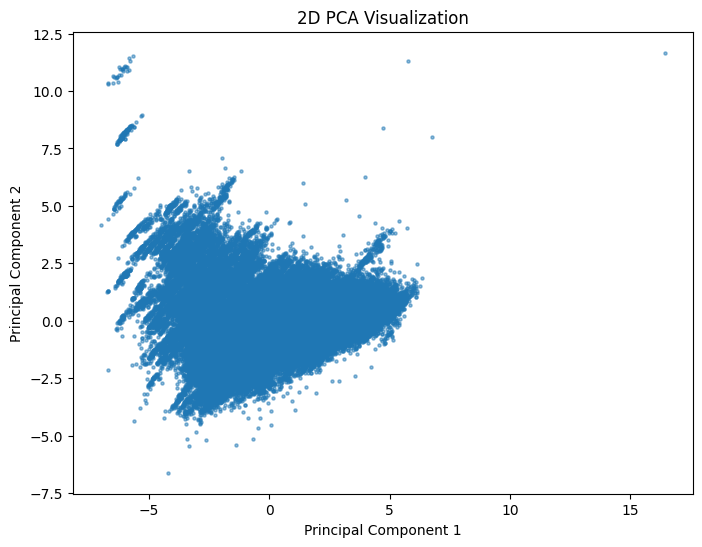

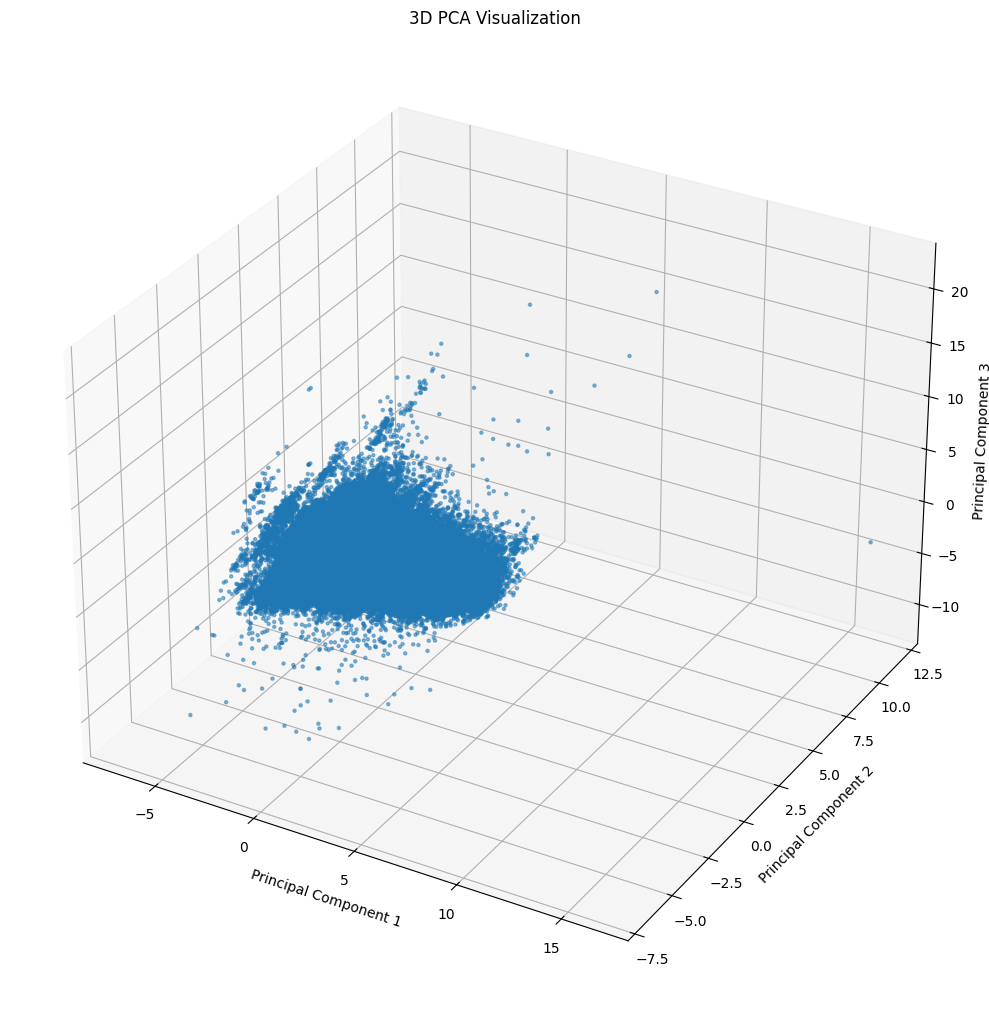

(27.389673279458243, 33.77155981006329)

In [ ]:
# Perform PCA with n_components=2
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(df_scaled)

# Perform PCA with n_components=3
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(df_scaled)

# Variance explained by the first 2 and 3 principal components
variance_2d = np.sum(pca_2d.explained_variance_ratio_) * 100
variance_3d = np.sum(pca_3d.explained_variance_ratio_) * 100

# Visualizing the 2D PCA result
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], alpha=0.5, s=5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Visualization')
plt.show()

# Visualizing the 3D PCA result
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], alpha=0.5, s=5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')
plt.tight_layout()
plt.show()


# Display the variance retained in 2D and 3D
variance_2d, variance_3d


The variance retained in the PCA transformation is:

* 2D PCA: ~27.39% of the variance.

* 3D PCA: ~33.77% of the variance.




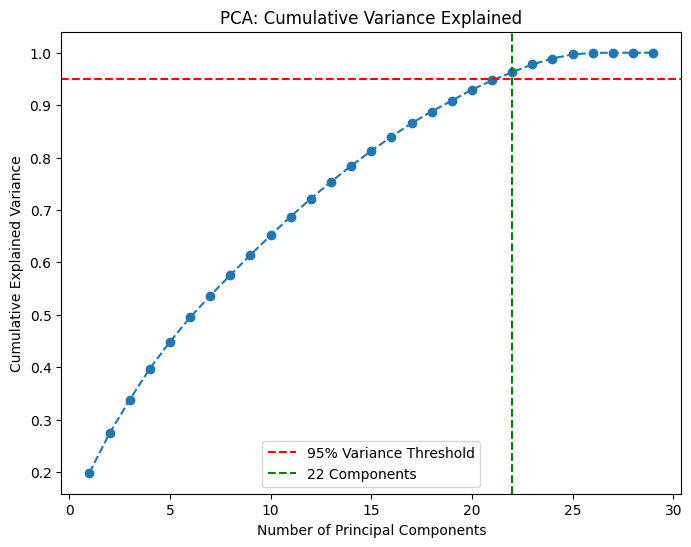

(22, array([5.55650341, 2.11269302, 1.78694871]))

In [ ]:
# Perform PCA on the full dataset to check cumulative variance
pca_full = PCA()
pca_full.fit(df_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find the number of components needed to retain at least 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Plot cumulative variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Variance Explained')
plt.legend()
plt.show()

# Extract the top three eigenvalues
top_three_eigenvalues = pca_full.explained_variance_[:3]

# Display the number of components needed and top three eigenvalues
n_components_95, top_three_eigenvalues


#### **Final Results of PCA Analysis:**

To retain at least 95% variance, 22 principal components are required.

**Top three eigenvalues:**

* 5.5565
* 2.1127
* 1.7869

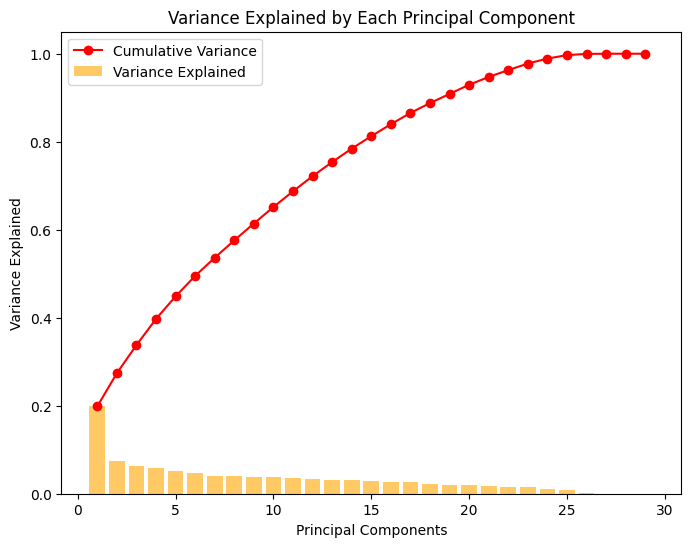

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df_scaled is the standardized dataset
pca = PCA()
pca.fit(df_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the variance explained and cumulative variance
plt.figure(figsize=(8, 6))

# Bar plot for individual variance explained by each component
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, color='orange', label='Variance Explained')

# Line plot for cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', linestyle='-', label='Cumulative Variance')

plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Principal Component')
plt.legend()
plt.show()


In [ ]:
# Creating DataFrames
df_pca_2d = pd.DataFrame(pca_2d_result, columns=['PC1', 'PC2'])
df_pca_3d = pd.DataFrame(pca_3d_result, columns=['PC1', 'PC2', 'PC3'])

In [ ]:
df_pca_2d

PC1       PC2
0      0.414679  1.556572
1      1.042350  2.151985
2      0.046534  1.086262
3      0.287924  1.098551
4      0.522028  1.458659
...         ...       ...
87225  1.071810  0.387851
87226  1.943175  1.393421
87227  1.587344  1.037849
87228  1.390512  0.794931
87229  0.072080  1.465013

[87230 rows x 2 columns]

In [ ]:
df_pca_3d

PC1       PC2       PC3
0      0.414679  1.556572 -0.543178
1      1.042350  2.151985  1.098192
2      0.046534  1.086262 -2.315316
3      0.287924  1.098551 -1.780846
4      0.522028  1.458659 -1.302956
...         ...       ...       ...
87225  1.071810  0.387851  1.259553
87226  1.943175  1.393421  0.661739
87227  1.587344  1.037849  0.343549
87228  1.390512  0.794931  0.459801
87229  0.072080  1.465013  2.506239

[87230 rows x 3 columns]

## **Clustering**

Variance retained after PCA (3 components): 33.77%


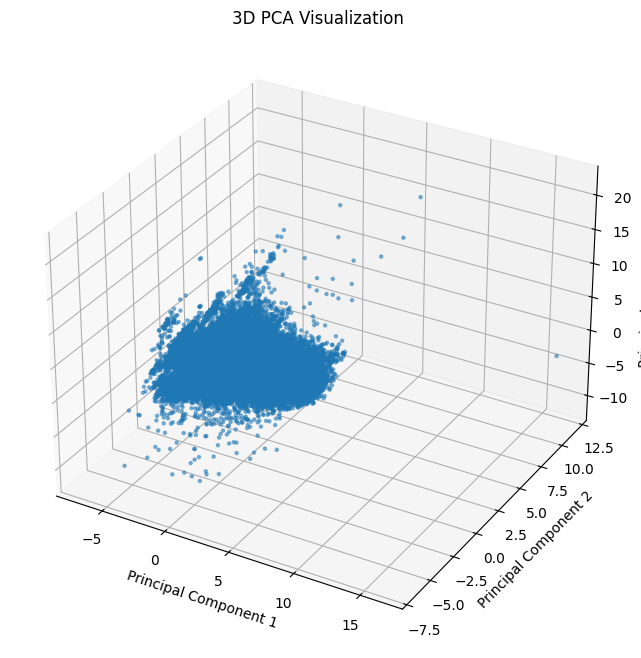

In [4]:
cluster_df = pd.read_csv('final_hotel_bookings_df_cleaned.csv')

# Step 1: Choose a labeled dataset for clustering
label_column = "is_canceled"
labels = cluster_df[label_column]  # Store labels separately

# Step 2: Remove categorical columns
categorical_columns = cluster_df.select_dtypes(include=['object', 'bool']).columns
categorical_encoded_columns = ['is_canceled', 'is_repeated_guest', 'arrival_date_year']
df_clustering_ready = cluster_df.drop(columns=list(categorical_columns) + categorical_encoded_columns, axis=1)

# Step 3: Normalize the numerical data using StandardScaler
scaler = StandardScaler()
cluster_df_scaled = scaler.fit_transform(df_clustering_ready)
cluster_df_scaled = pd.DataFrame(cluster_df_scaled, columns=df_clustering_ready.columns)

# Step 4: Perform PCA (Optional) to Reduce to 3D
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(cluster_df_scaled)

# Variance explained by the first 3 principal components
variance_3d = np.sum(pca_3d.explained_variance_ratio_) * 100
print(f"Variance retained after PCA (3 components): {variance_3d:.2f}%")

# Step 5: 3D Scatter Plot of PCA-Reduced Data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], alpha=0.5, s=5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')
plt.show()

In [5]:
cluster_df_scaled

lead_time  arrival_date_week_number  arrival_date_day_of_month  \
0       3.044788                  0.012064                  -1.676854   
1       7.634706                  0.012064                  -1.676854   
2      -0.847926                  0.012064                  -1.676854   
3      -0.778206                  0.012064                  -1.676854   
4      -0.766586                  0.012064                  -1.676854   
...          ...                       ...                        ...   
87225  -0.662006                  0.597324                   1.605362   
87226   0.255978                  0.597324                   1.718542   
87227  -0.534185                  0.597324                   1.718542   
87228   0.337318                  0.597324                   1.718542   
87229   1.452842                  0.597324                   1.492182   

       stays_in_weekend_nights  stays_in_week_nights    adults  children  \
0                    -0.977814             -1.286352  0.194034 -0.304424   
1                    -0.977814             -1.286352  0.194034 -0.304424   
2                    -0.977814             -0.796113 -1.414406 -0.304424   
3                    -0.977814             -0.796113 -1.414406 -0.304424   
4                    -0.977814             -0.305873  0.194034 -0.304424   
...                        ...                   ...       ...       ...   
87225                 0.968843              1.164846  0.194034 -0.304424   
87226                 0.968843              1.164846  1.802474 -0.304424   
87227                 0.968843              1.164846  0.194034 -0.304424   
87228                 0.968843              1.164846  0.194034 -0.304424   
87229                 0.968843              2.145325  0.194034 -0.304424   

         babies  previous_cancellations  previous_bookings_not_canceled  ...  \
0     -0.095379               -0.082315                       -0.106204  ...   
1     -0.095379               -0.082315                       -0.106204  ...   
2     -0.095379               -0.082315                       -0.106204  ...   
3     -0.095379               -0.082315                       -0.106204  ...   
4     -0.095379               -0.082315                       -0.106204  ...   
...         ...                     ...                             ...  ...   
87225 -0.095379               -0.082315                       -0.106204  ...   
87226 -0.095379               -0.082315                       -0.106204  ...   
87227 -0.095379               -0.082315                       -0.106204  ...   
87228 -0.095379               -0.082315                       -0.106204  ...   
87229 -0.095379               -0.082315                       -0.106204  ...   

       feels_like_temp  humidity  precipitation  precipitation_probability  \
0             0.502384  0.354578      -0.279184                  -0.572682   
1             0.502384  0.354578      -0.279184                  -0.572682   
2             0.502384  0.354578      -0.279184                  -0.572682   
3             0.502384  0.354578      -0.279184                  -0.572682   
4             0.502384  0.354578      -0.279184                  -0.572682   
...                ...       ...            ...                        ...   
87225         0.502384  0.940915      -0.279184                  -0.572682   
87226         0.581216  0.669734      -0.279184                  -0.572682   
87227         0.581216  0.669734      -0.279184                  -0.572682   
87228         0.581216  0.669734      -0.279184                  -0.572682   
87229         0.246182  1.307376      -0.125179                   1.746170   

       snowfall  max_wind_gust  avg_wind_speed  visibility_km  cloud_cover  \
0           0.0       1.172175        1.995870      -0.233596     0.040924   
1           0.0       1.172175        1.995870      -0.233596     0.040924   
2           0.0       1.172175        1.995870      -0.233596     0.040924   
3      

In [6]:
df_pca_3d = pd.DataFrame(pca_3d_result, columns=['PC1', 'PC2', 'PC3'])

df_pca_3d

PC1       PC2       PC3
0      0.414679  1.556572 -0.543178
1      1.042350  2.151985  1.098192
2      0.046534  1.086262 -2.315316
3      0.287924  1.098551 -1.780846
4      0.522028  1.458659 -1.302956
...         ...       ...       ...
87225  1.071810  0.387851  1.259553
87226  1.943175  1.393421  0.661739
87227  1.587344  1.037849  0.343549
87228  1.390512  0.794931  0.459801
87229  0.072080  1.465013  2.506239

[87230 rows x 3 columns]

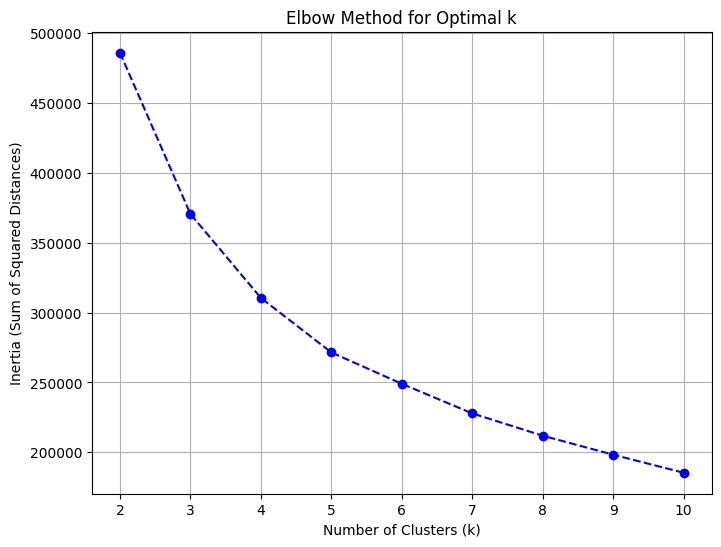

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Define k values to test
k_values = range(2, 11)  # Checking k from 2 to 10
inertia_scores = []

# Step 2: Run KMeans for each k and record inertia (within-cluster sum of squares)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_3d_result)
    inertia_scores.append(kmeans.inertia_)

# Step 3: Plot Elbow Method Graph
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


2
3
4
5
6
7
8


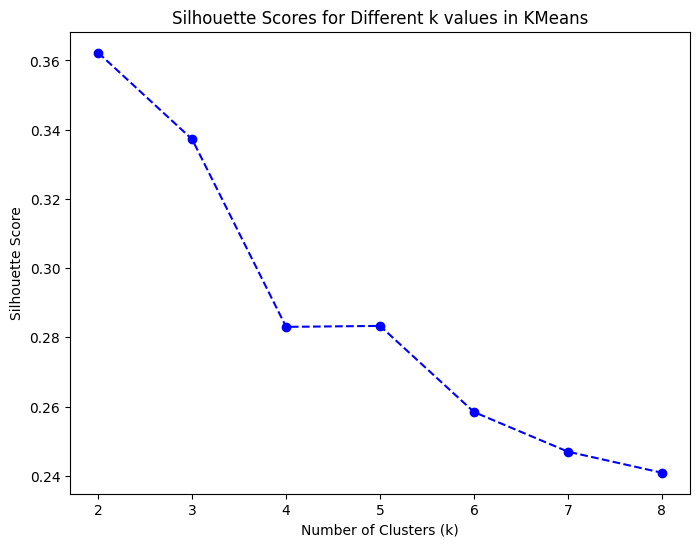

Top 3 optimal k values: [(2, 0.3622199802632861), (3, 0.3372042583219833), (5, 0.28331292751102227)]


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Compute silhouette scores to find the best k
k_values = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(pca_3d_result)

    # Compute silhouette score
    print(k)
    score = silhouette_score(pca_3d_result, cluster_labels)
    silhouette_scores.append(score)

# Step 2: Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k values in KMeans')
plt.show()

# Step 3: Select the best 3 k values
optimal_k_values = sorted(zip(k_values, silhouette_scores), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 optimal k values:", optimal_k_values)


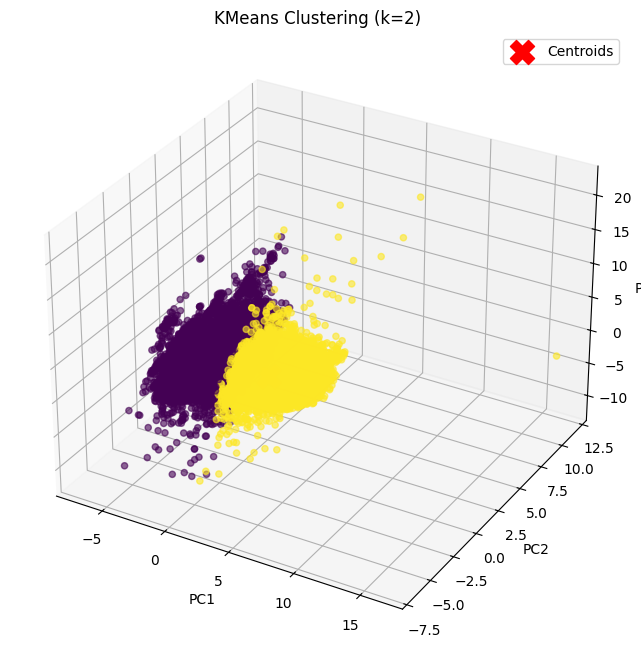

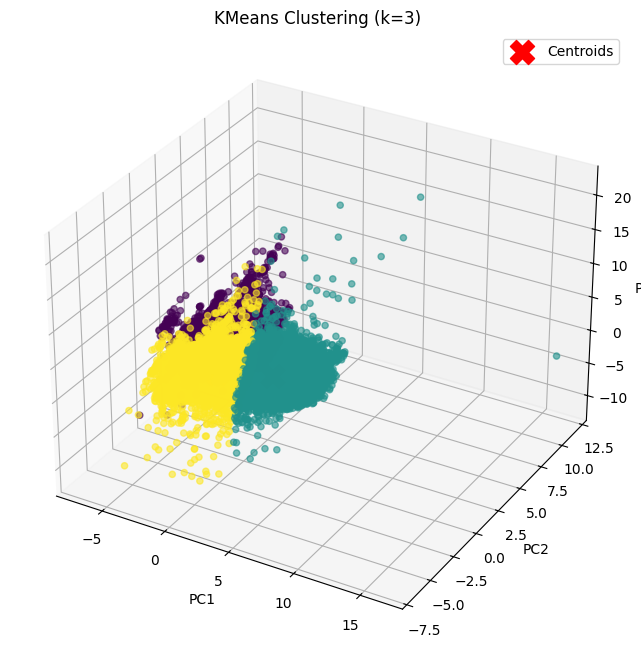

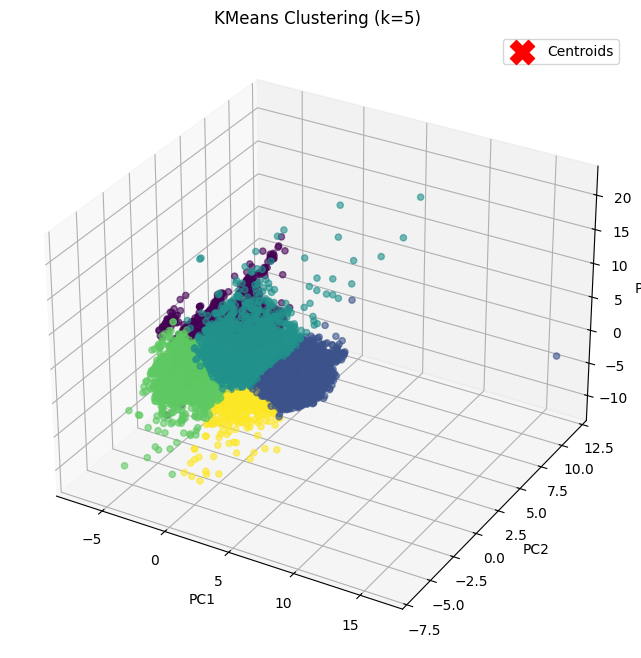

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Plot clusters for the top 3 k values
for k, _ in optimal_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=200)
    cluster_labels = kmeans.fit_predict(pca_3d_result)
    centroids = kmeans.cluster_centers_

    # 3D Visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=cluster_labels, cmap='viridis', alpha=0.6)

    # Plot centroids
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='X', s=300, c='red', label='Centroids')

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'KMeans Clustering (k={k})')
    ax.legend()
    plt.show()


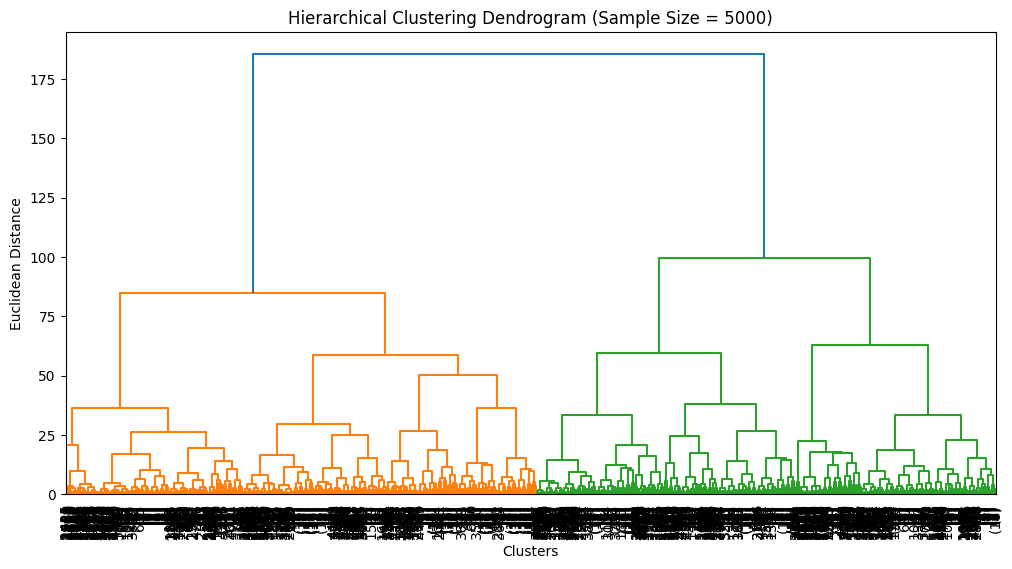

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Randomly sample 5000 points to avoid memory crash
sample_size = 5000
sample_indices = np.random.choice(len(pca_3d_result), size=sample_size, replace=False)
pca_sample = pca_3d_result[sample_indices]

from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Compute hierarchical clustering on sampled data
linked = linkage(pca_sample, method='ward')

# Step 2: Plot a cleaner dendrogram
plt.figure(figsize=(12, 6))

dendrogram(
    linked,
    truncate_mode='level',  # Show only higher-level clusters
    p=10,  # Number of clusters to show
    leaf_rotation=90,  # Rotate labels for readability
    leaf_font_size=10,  # Adjust label size
)

plt.title(f'Hierarchical Clustering Dendrogram (Sample Size = {sample_size})')
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.show()


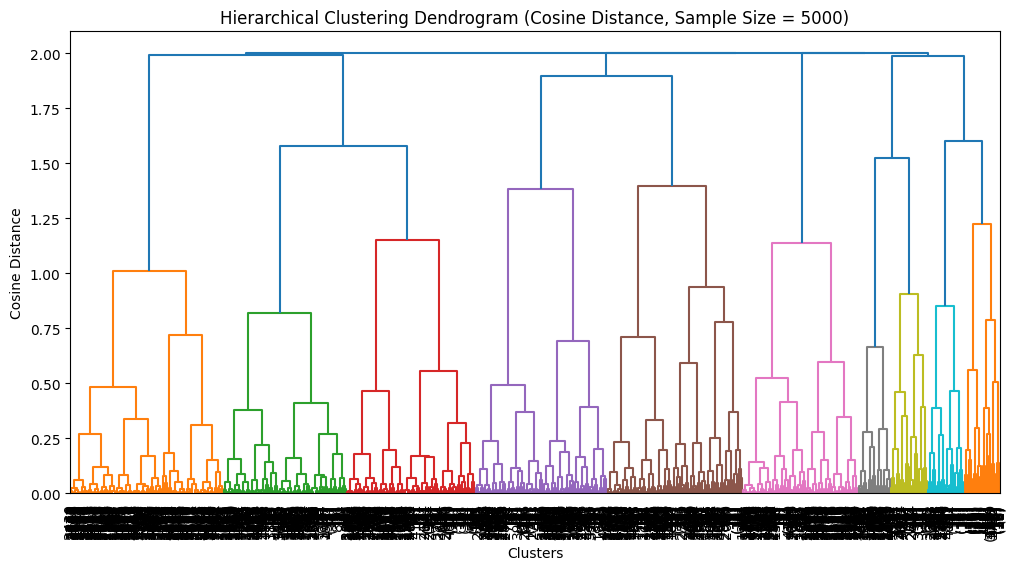

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Randomly sample 5000 points (to avoid memory crash)
sample_size = 5000
sample_indices = np.random.choice(len(pca_3d_result), size=sample_size, replace=False)
pca_sample = pca_3d_result[sample_indices]

# Step 2: Compute cosine distance matrix
cosine_distances = pdist(pca_sample, metric='cosine')

# Step 3: Compute hierarchical clustering using cosine distance
linked = linkage(cosine_distances, method='complete')  # "complete" works better with cosine

# Step 4: Plot a cleaner dendrogram
plt.figure(figsize=(12, 6))

dendrogram(
    linked,
    truncate_mode='level',  # Show only higher-level clusters
    p=10,  # Show top 10 clusters
    leaf_rotation=90,  # Rotate labels for readability
    leaf_font_size=10,  # Adjust label size
)

plt.title(f'Hierarchical Clustering Dendrogram (Cosine Distance, Sample Size = {sample_size})')
plt.xlabel('Clusters')
plt.ylabel('Cosine Distance')
plt.show()


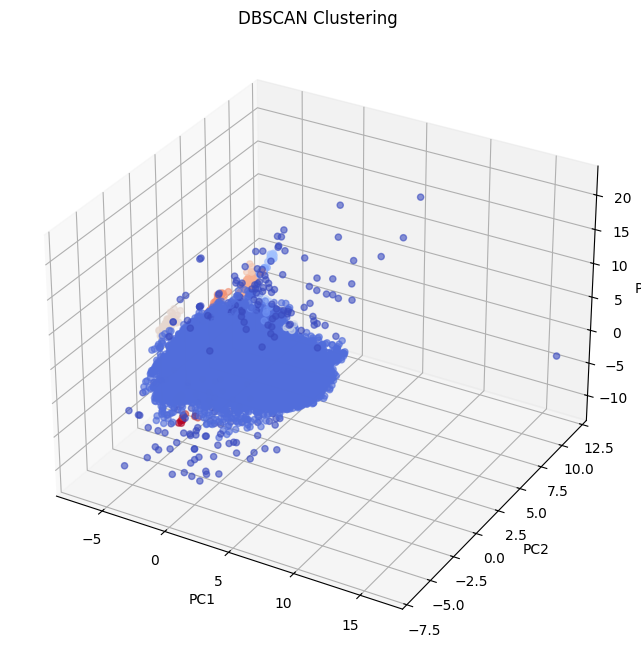

In [ ]:
from sklearn.cluster import DBSCAN

# Step 1: Apply DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)  # Adjust eps based on density
dbscan_labels = dbscan.fit_predict(pca_3d_result)

# Step 2: Visualize DBSCAN Clustering
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2], c=dbscan_labels, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('DBSCAN Clustering')
plt.show()


<ipython-input-15-9ec1a03d7bc6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")


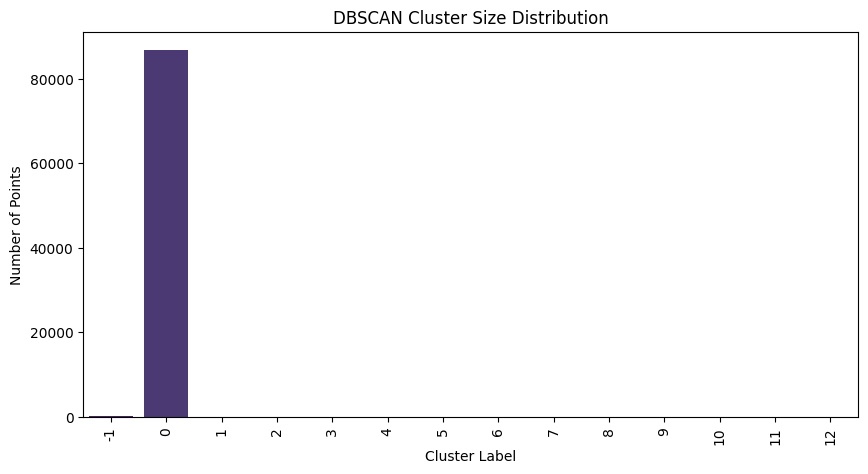

In [ ]:
import seaborn as sns
import pandas as pd

# Step 1: Count points per cluster
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()

# Step 2: Plot cluster sizes
plt.figure(figsize=(10, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

plt.xlabel('Cluster Label')
plt.ylabel('Number of Points')
plt.title('DBSCAN Cluster Size Distribution')
plt.xticks(rotation=90)
plt.show()


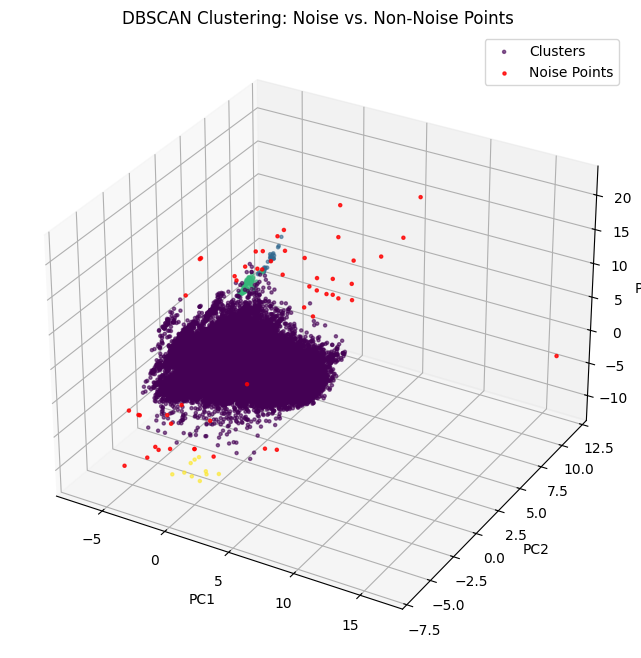

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# Step 1: Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_3d_result)

# Step 2: Identify Noise & Non-Noise Points
core_mask = dbscan_labels != -1  # Non-noise points (Clusters)
noise_mask = dbscan_labels == -1  # Noise points

# Step 3: 3D Plot of Clusters vs. Noise
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot non-noise points (clusters)
ax.scatter(
    pca_3d_result[core_mask, 0],
    pca_3d_result[core_mask, 1],
    pca_3d_result[core_mask, 2],
    c=dbscan_labels[core_mask], cmap='viridis', s=5, alpha=0.6, label="Clusters"
)

# Plot noise points in red
ax.scatter(
    pca_3d_result[noise_mask, 0],
    pca_3d_result[noise_mask, 1],
    pca_3d_result[noise_mask, 2],
    c='red', s=5, alpha=0.8, label="Noise Points"
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('DBSCAN Clustering: Noise vs. Non-Noise Points')
ax.legend()
plt.show()


## **ARM**

In [ ]:
arm_df = pd.read_csv('final_hotel_bookings_df_cleaned.csv')

In [ ]:
arm_df

hotel  is_canceled  lead_time  arrival_date_year  \
0      Resort Hotel            0        342               2015   
1      Resort Hotel            0        737               2015   
2      Resort Hotel            0          7               2015   
3      Resort Hotel            0         13               2015   
4      Resort Hotel            0         14               2015   
...             ...          ...        ...                ...   
87225    City Hotel            0         23               2017   
87226    City Hotel            0        102               2017   
87227    City Hotel            0         34               2017   
87228    City Hotel            0        109               2017   
87229    City Hotel            0        205               2017   

      arrival_date_month  arrival_date_week_number  arrival_date_day_of_month  \
0                   July                        27                          1   
1                   July                        27                          1   
2                   July                        27                          1   
3                   July                        27                          1   
4                   July                        27                          1   
...                  ...                       ...                        ...   
87225             August                        35                         30   
87226             August                        35                         31   
87227             August                        35                         31   
87228             August                        35                         31   
87229             August                        35                         29   

       stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                            0                     0       2  ...   
1                            0                     0       2  ...   
2                            0                     1       1  ...   
3                            0                     1       1  ...   
4                            0                     2       2  ...   
...                        ...                   ...     ...  ...   
87225                        2                     5       2  ...   
87226                        2                     5       3  ...   
87227                        2                     5       2  ...   
87228                        2                     5       2  ...   
87229                        2                     7       2  ...   

       precipitation_probability  snowfall max_wind_gust avg_wind_speed  \
0                              0         0          54.0           38.5   
1                              0         0          54.0           38.5   
2                              0         0          54.0           38.5   
3                              0         0          54.0           38.5   
4                              0         0          54.0           38.5   
...                          ...       ...           ...            ...   
87225                          0         0          45.7           24.1   
87226                          0         0          47.2           31.1   
87227                          0         0          47.2           31.1   
87228                          0         0          47.2           31.1   
87229                        100         0          38.9           21.9   

      visibility_km cloud_cover      weather_conditions  is_holiday_week  \
0              11.0        35.6        Partially cloudy             True   
1              11.0        35.6        Partially cloudy             True   
2              11.0        35.6        Partially cloudy             True   
3              11.0        35.6        Partially cloudy             True   
4              11.0        35.6        Partially cloudy             True   
...             ...         ...                     ...       

In [ ]:
# Select categorical columns that represent transaction items
categorical_cols = [
    "hotel", "meal", "market_segment", "distribution_channel",
    "reserved_room_type", "assigned_room_type", "deposit_type",
    "customer_type", "reservation_status", "weather_conditions", "nearest_holiday"
]


# Keep only categorical data for ARM
arm_df_transactions = arm_df[categorical_cols]

arm_df_transactions = arm_df_transactions.applymap(lambda x: str(x).replace(',', '-'))

arm_df_transactions = arm_df_transactions.applymap(lambda x: str(x).replace('"', '').replace("'", ''))

# Save the transaction dataset for use in R
transaction_file = "transactions_arm.csv"
arm_df_transactions.to_csv(transaction_file, index=False, header=False)

# Display a sample of the transactions
arm_df_transactions.head()


<ipython-input-4-9c60a1a56135>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  arm_df_transactions = arm_df_transactions.applymap(lambda x: str(x).replace(',', '-'))
<ipython-input-4-9c60a1a56135>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  arm_df_transactions = arm_df_transactions.applymap(lambda x: str(x).replace('"', '').replace("'", ''))


hotel meal market_segment distribution_channel reserved_room_type  \
0  Resort Hotel   BB         Direct               Direct                  C   
1  Resort Hotel   BB         Direct               Direct                  C   
2  Resort Hotel   BB         Direct               Direct                  A   
3  Resort Hotel   BB      Corporate            Corporate                  A   
4  Resort Hotel   BB      Online TA                TA/TO                  A   

  assigned_room_type deposit_type customer_type reservation_status  \
0                  C   No Deposit     Transient          Check-Out   
1                  C   No Deposit     Transient          Check-Out   
2                  C   No Deposit     Transient          Check-Out   
3                  A   No Deposit     Transient          Check-Out   
4                  A   No Deposit     Transient          Check-Out   

  weather_conditions nearest_holiday  
0   Partially cloudy     Madeira Day  
1   Partially cloudy     Madeira Day  
2   Partially cloudy     Madeira Day  
3   Partially cloudy     Madeira Day  
4   Partially cloudy     Madeira Day

In [ ]:
arm_df_transactions = pd.read_csv('transactions_arm.csv',header=None)

In [ ]:
arm_df_transactions

0   1              2          3  4  5           6   \
0      Resort Hotel  BB         Direct     Direct  C  C  No Deposit   
1      Resort Hotel  BB         Direct     Direct  C  C  No Deposit   
2      Resort Hotel  BB         Direct     Direct  A  C  No Deposit   
3      Resort Hotel  BB      Corporate  Corporate  A  A  No Deposit   
4      Resort Hotel  BB      Online TA      TA/TO  A  A  No Deposit   
...             ...  ..            ...        ... .. ..         ...   
87225    City Hotel  BB  Offline TA/TO      TA/TO  A  A  No Deposit   
87226    City Hotel  BB      Online TA      TA/TO  E  E  No Deposit   
87227    City Hotel  BB      Online TA      TA/TO  D  D  No Deposit   
87228    City Hotel  BB      Online TA      TA/TO  A  A  No Deposit   
87229    City Hotel  HB      Online TA      TA/TO  A  A  No Deposit   

              7          8                       9               10  
0      Transient  Check-Out        Partially cloudy     Madeira Day  
1      Transient  Check-Out        Partially cloudy     Madeira Day  
2      Transient  Check-Out        Partially cloudy     Madeira Day  
3      Transient  Check-Out        Partially cloudy     Madeira Day  
4      Transient  Check-Out        Partially cloudy     Madeira Day  
...          ...        ...                     ...             ...  
87225  Transient  Check-Out        Partially cloudy  Assumption Day  
87226  Transient  Check-Out        Partially cloudy  Assumption Day  
87227  Transient  Check-Out        Partially cloudy  Assumption Day  
87228  Transient  Check-Out        Partially cloudy  Assumption Day  
87229  Transient  Check-Out  Rain- Partially cloudy  Assumption Day  

[87230 rows x 11 columns]

In [1]:
install.packages("arules")
install.packages("arulesViz")

library(arules)
library(arulesViz)

resort <- read.transactions("transactions_arm.csv",
                             rm.duplicates = FALSE,
                             format = "basket",
                             sep=",",
                             cols=NULL)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘permute’, ‘zoo’, ‘tweenr’, ‘polyclip’, ‘RcppEigen’, ‘gridExtra’, ‘RcppArmadillo’, ‘ca’, ‘foreach’, ‘gclus’, ‘qap’, ‘registry’, ‘TSP’, ‘vegan’, ‘lmtest’, ‘ggforce’, ‘ggrepel’, ‘viridis’, ‘tidygraph’, ‘graphlayouts’, ‘crosstalk’, ‘lazyeval’, ‘seriation’, ‘vcd’, ‘igraph’, ‘scatterplot3d’, ‘ggraph’, ‘DT’, ‘plotly’, ‘visNetwork’


Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write


Warning message in asMethod(object):
“removing duplicated items in transactions”


In [2]:
inspect(resort[1:10])

     items              
[1]  {BB,               
      C,                
      Check-Out,        
      Direct,           
      Madeira Day,      
      No Deposit,       
      Partially cloudy, 
      Resort Hotel,     
      Transient}        
[2]  {BB,               
      C,                
      Check-Out,        
      Direct,           
      Madeira Day,      
      No Deposit,       
      Partially cloudy, 
      Resort Hotel,     
      Transient}        
[3]  {A,                
      BB,               
      C,                
      Check-Out,        
      Direct,           
      Madeira Day,      
      No Deposit,       
      Partially cloudy, 
      Resort Hotel,     
      Transient}        
[4]  {A,                
      BB,               
      Check-Out,        
      Corporate,        
      Madeira Day,      
      No Deposit,       
      Partially cloudy, 
      Resort Hotel,     
      Transient}        
[5]  {A,                
      BB,               


In [3]:
resort_list <- as(resort, "list")  # Convert transactions to a list


In [4]:
resort_df <- data.frame(Transaction_ID = seq_along(resort_list),
                        Items = sapply(resort_list, function(x) paste(x, collapse = ", ")))  # Combine items into a single column

View(resort_df)  # Opens the table in RStudio


Transaction_ID
1      1            
2      2            
3      3            
4      4            
5      5            
6      6            
7      7            
8      8            
9      9            
10    10            
11    11            
12    12            
13    13            
14    14            
15    15            
16    16            
17    17            
18    18            
19    19            
20    20            
21    21            
22    22            
23    23            
24    24            
25    25            
26    26            
27    27            
28    28            
29    29            
30    30            
⋮     ⋮             
87201 87201         
87202 87202         
87203 87203         
87204 87204         
87205 87205         
87206 87206         
87207 87207         
87208 87208         
87209 87209         
87210 87210         
87211 87211         
87212 87212         
87213 87213         
87214 87214         
87215 87215         
87216 87216         
87217 87217         
87218 87218         
87219 87219         
87220 87220         
87221 87221         
87222 87222         
87223 87223         
87224 87224         
87225 87225         
87226 87226         
87227 87227         
87228 87228         
87229 87229         
87230 87230         
      Items                                                                                                        
1     BB, C, Check-Out, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
2     BB, C, Check-Out, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
3     A, BB, C, Check-Out, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient              
4     A, BB, Check-Out, Corporate, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient              
5     A, BB, Check-Out, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient       
6     BB, C, Check-Out, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
7     C, Check-Out, Direct, FB, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
8     A, BB, Canceled, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient        
9     Canceled, D, HB, Madeira Day, No Deposit, Offline TA/TO, Partially cloudy, Resort Hotel, TA/TO, Transient    
10    BB, Canceled, E, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient        
11    Check-Out, D, HB, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient       
12    BB, Check-Out, D, E, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient    
13    Check-Out, G, HB, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient       
14    BB, Check-Out, E, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient       
15    BB, Check-Out, D, E, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient    
16    BB, Check-Out, Contract, E, Madeira Day, No Deposit, Offline TA/TO, Partially cloudy, Resort Hotel, TA/TO    
17    A, BB, Check-Out, E, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient    
18    A, BB, Check-Out, Corporate, G, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient           
19    BB, Check-Out, Direct, G, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
20    BB, Check-Out, F, Madeira Day, No Deposit, Online TA, Partially cloudy, Resort Hotel, TA/TO, Transient       
21    A, BB, Check-Out, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
22    BB, Check-Out, D, Direct, Madeira Day, No Deposit, Partially cloudy, Resort Hotel, Transient                 
23    Check-Out, Contract, D, HB, I,

## **R Code for ARM Rules**

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write


Warning message in asMethod(object):
“removing duplicated items in transactions”


Streaming output truncated to the last 5000 lines.
[86727] {A,                           
         Assumption Day,              
         BB,                          
         Check-Out,                   
         City Hotel,                  
         Groups,                      
         No Deposit,                  
         Partially cloudy,            
         TA/TO,                       
         Transient-Party}             
[86728] {A,                           
         Assumption Day,              
         BB,                          
         Check-Out,                   
         City Hotel,                  
         No Deposit,                  
         Offline TA/TO,               
         Partially cloudy,            
         TA/TO,                       
         Transient-Party}             
[86729] {A,                           
         Assumption Day,              
         BB,                          
         Check-Out,                   
         City

set of 292 rules

rule length distribution (lhs + rhs):sizes
  2   3   4   5 
 59 131  92  10 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   3.000   3.000   3.182   4.000   5.000 

summary of quality measures:
    support         confidence        coverage           lift       
 Min.   :0.3511   Min.   :0.5269   Min.   :0.3563   Min.   :0.8899  
 1st Qu.:0.3727   1st Qu.:0.6945   1st Qu.:0.4839   1st Qu.:0.9660  
 Median :0.4149   Median :0.7639   Median :0.5755   Median :0.9998  
 Mean   :0.4515   Mean   :0.7943   Mean   :0.5808   Mean   :1.0344  
 3rd Qu.:0.5069   3rd Qu.:0.9173   3rd Qu.:0.6431   3rd Qu.:1.0564  
 Max.   :0.8138   Max.   :1.0000   Max.   :0.9869   Max.   :1.4841  
     count      
 Min.   :30626  
 1st Qu.:32512  
 Median :36193  
 Mean   :39386  
 3rd Qu.:44216  
 Max.   :70987  

mining info:
   data ntransactions support confidence
 resort         87230    0.35        0.5
                                                                              


--- Top 15 Rules by Support ---
     lhs                        rhs          support   confidence coverage 
[1]  {Transient}             => {No Deposit} 0.8137911 0.9878239  0.8238221
[2]  {No Deposit}            => {Transient}  0.8137911 0.8246152  0.9868738
[3]  {TA/TO}                 => {No Deposit} 0.7805801 0.9864113  0.7913333
[4]  {No Deposit}            => {TA/TO}      0.7805801 0.7909624  0.9868738
[5]  {BB}                    => {No Deposit} 0.7673392 0.9856863  0.7784822
[6]  {No Deposit}            => {BB}         0.7673392 0.7775454  0.9868738
[7]  {Check-Out}             => {No Deposit} 0.7232030 0.9978488  0.7247621
[8]  {No Deposit}            => {Check-Out}  0.7232030 0.7328222  0.9868738
[9]  {TA/TO}                 => {Transient}  0.6509114 0.8225503  0.7913333
[10] {Transient}             => {TA/TO}      0.6509114 0.7901116  0.8238221
[11] {BB}                    => {Transient}  0.6430700 0.8260562  0.7784822
[12] {Transient}             => {BB}         0.6430700 

set of 292 rules

rule length distribution (lhs + rhs):sizes
  2   3   4   5 
 59 131  92  10 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   3.000   3.000   3.182   4.000   5.000 

summary of quality measures:
    support         confidence        coverage           lift       
 Min.   :0.3511   Min.   :0.5269   Min.   :0.3563   Min.   :0.8899  
 1st Qu.:0.3727   1st Qu.:0.6945   1st Qu.:0.4839   1st Qu.:0.9660  
 Median :0.4149   Median :0.7639   Median :0.5755   Median :0.9998  
 Mean   :0.4515   Mean   :0.7943   Mean   :0.5808   Mean   :1.0344  
 3rd Qu.:0.5069   3rd Qu.:0.9173   3rd Qu.:0.6431   3rd Qu.:1.0564  
 Max.   :0.8138   Max.   :1.0000   Max.   :0.9869   Max.   :1.4841  
     count      
 Min.   :30626  
 1st Qu.:32512  
 Median :36193  
 Mean   :39386  
 3rd Qu.:44216  
 Max.   :70987  

mining info:
   data ntransactions support confidence
 resort         87230    0.35        0.5
                                                                              

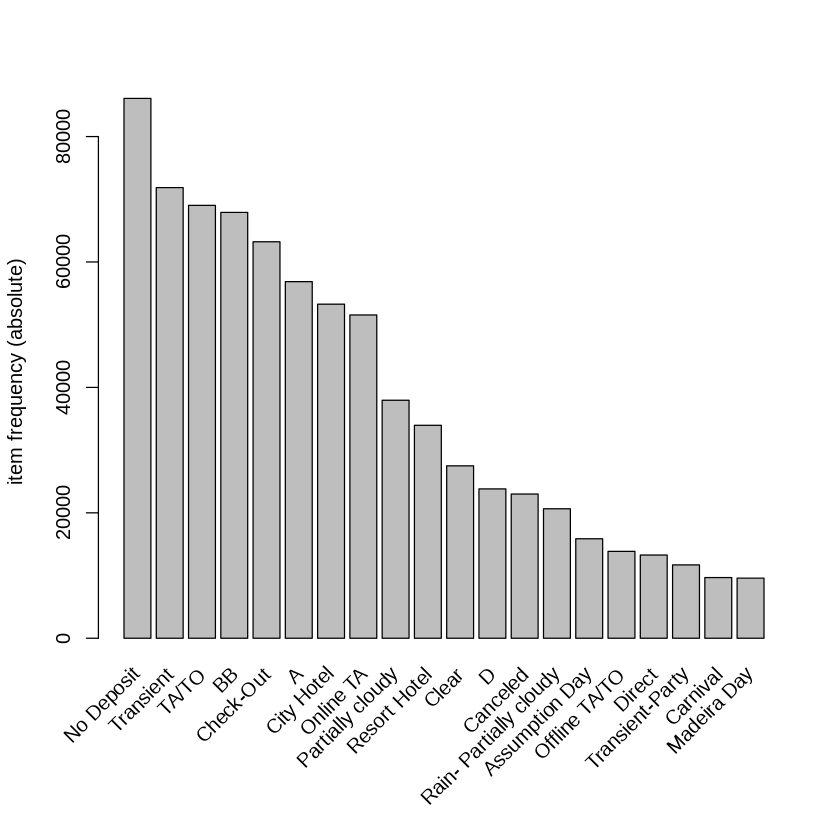

In [ ]:
# Install and load necessary libraries
install.packages("arules")
install.packages("arulesViz")

library(arules)
library(arulesViz)

# Load transaction data
resort <- read.transactions("transactions_arm.csv",
                             rm.duplicates = FALSE,
                             format = "basket",
                             sep=",",
                             cols=NULL)

# Inspect a few transactions
inspect(resort)

# Apply Apriori Algorithm
Frules <- apriori(resort, parameter = list(support=0.35, confidence=0.5, minlen=2))

# Print summary of rules
summary(Frules)

# Print the top 15 rules sorted by Support
cat("\n--- Top 15 Rules by Support ---\n")
inspect(sort(Frules, by="support")[1:15])

# Print the top 15 rules sorted by Confidence
cat("\n--- Top 15 Rules by Confidence ---\n")
inspect(sort(Frules, by="confidence")[1:15])

# Print the top 15 rules sorted by Lift
cat("\n--- Top 15 Rules by Lift ---\n")
inspect(sort(Frules, by="lift")[1:15])

# Plot most frequent items
itemFrequencyPlot(resort, topN=20, type="absolute")

# Sort rules by Confidence
SortedRules <- sort(Frules, by="confidence", decreasing=TRUE)
inspect(SortedRules[1:10])
summary(SortedRules)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“Unknown control parameters: type, main”


Available control parameters (with default values):
layout	 =  stress
circular	 =  FALSE
ggraphdots	 =  NULL
edges	 =  <environment>
nodes	 =  <environment>
nodetext	 =  <environment>
colors	 =  c("#EE0000FF", "#EEEEEEFF")
engine	 =  ggplot2
max	 =  100
verbose	 =  FALSE


$title
[1] "Network Graph - Top 15 Rules by Support"

attr(,"class")
[1] "labels"

Warning message:
“Unknown control parameters: type, main”


Available control parameters (with default values):
layout	 =  stress
circular	 =  FALSE
ggraphdots	 =  NULL
edges	 =  <environment>
nodes	 =  <environment>
nodetext	 =  <environment>
colors	 =  c("#EE0000FF", "#EEEEEEFF")
engine	 =  ggplot2
max	 =  100
verbose	 =  FALSE


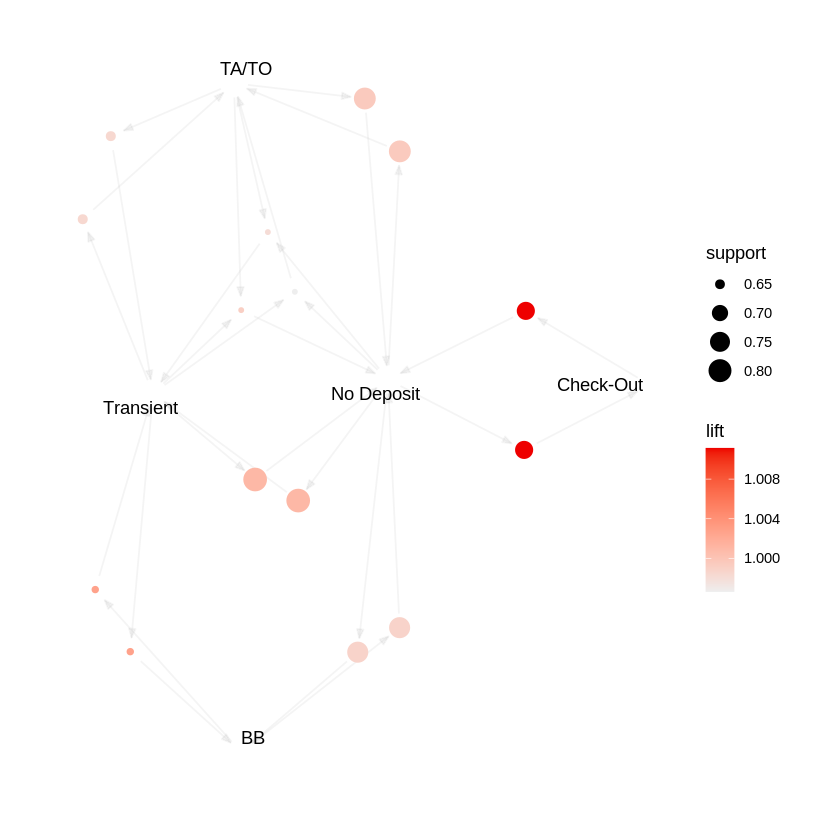

$title
[1] "Network Graph - Top 15 Rules by Confidence"

attr(,"class")
[1] "labels"

Warning message:
“Unknown control parameters: type, main”


Available control parameters (with default values):
layout	 =  stress
circular	 =  FALSE
ggraphdots	 =  NULL
edges	 =  <environment>
nodes	 =  <environment>
nodetext	 =  <environment>
colors	 =  c("#EE0000FF", "#EEEEEEFF")
engine	 =  ggplot2
max	 =  100
verbose	 =  FALSE


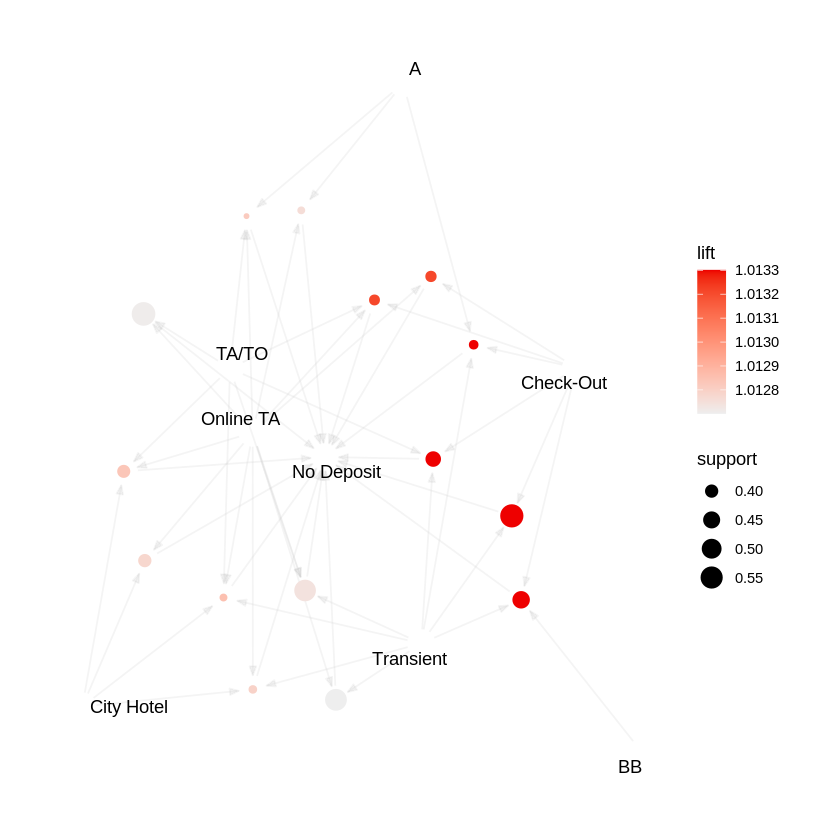

$title
[1] "Network Graph - Top 15 Rules by Lift"

attr(,"class")
[1] "labels"

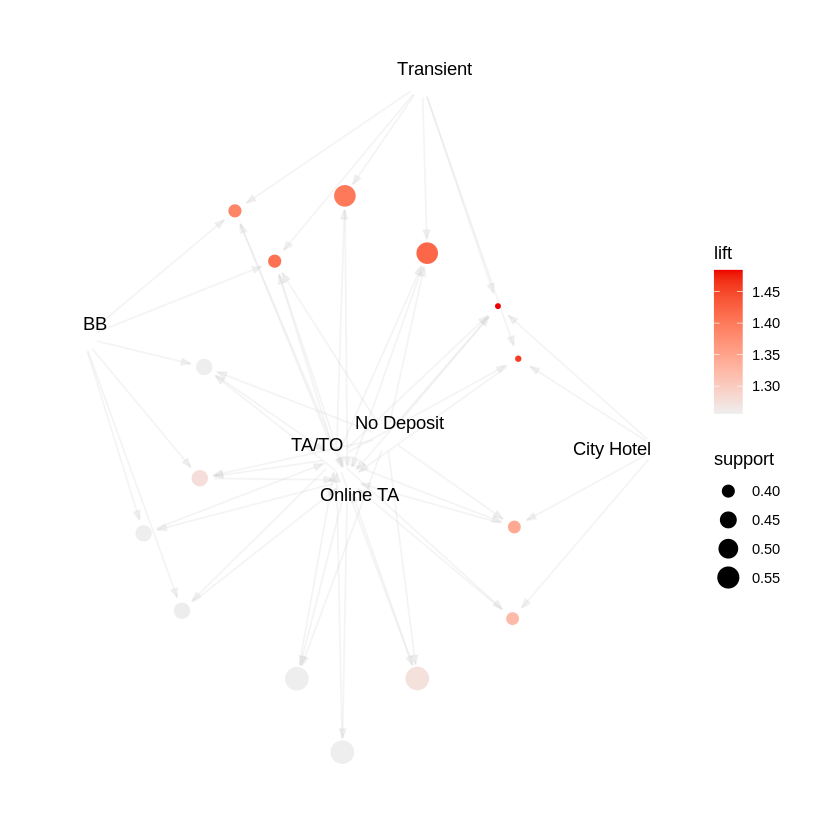

In [ ]:
# Install and load necessary libraries
install.packages("arules")
install.packages("arulesViz")
install.packages("igraph")
install.packages("ggplot2")
library(ggplot2)

library(arules)
library(arulesViz)
library(igraph)


# Step 3: Generate and Plot Network Graphs for Different Metrics

# Network Graph: Top Rules by Support
top_support <- sort(Frules, by="support")[1:15]
plot(top_support, method="graph", control=list(type="items"), main="Network Graph (Support)")
ggtitle("Network Graph - Top 15 Rules by Support")

# Network Graph: Top Rules by Confidence
top_confidence <- sort(Frules, by="confidence")[1:15]
plot(top_confidence, method="graph", control=list(type="items"), main="Network Graph (Confidence)")
ggtitle("Network Graph - Top 15 Rules by Confidence")

# Network Graph: Top Rules by Lift
top_lift <- sort(Frules, by="lift")[1:15]
plot(top_lift, method="graph", control=list(type="items"), main="Network Graph (Lift)")
ggtitle("Network Graph - Top 15 Rules by Lift")
